In [1]:
from selenium import webdriver
from time import sleep
from scrapy.selector import Selector
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from selenium.webdriver.chrome.options import Options
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from math import sin, cos, sqrt,atan2, radians
from matplotlib.lines import Line2D
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LassoCV

sns.set_style('whitegrid')

chrome_options = Options()
chrome_options.add_argument("--headless")


chromedriver = "/home/btan/Documents/chromedriver"
# driver = webdriver.Chrome(chromedriver, chrome_options = chrome_options)
# driver.close()

pd.set_option('mode.chained_assignment', None)

pd.options.display.float_format = '{:20,.2f}'.format

print('Update: Library import completed!')

Update: Library import completed!


In [2]:
# change path when got more data
houses = pd.read_csv('./datasets/houses-dataset-2019-05-21-1400.csv', index_col = 'Unnamed: 0')
schools = pd.read_csv('./datasets/schools-updated-2019-05-16.csv', index_col = 'Unnamed: 0')
trains = pd.read_csv('./datasets/sg-train-station-updated-2019-05-16.csv', index_col = 'Unnamed: 0')
print('Update: dataset import complete!')

Update: dataset import complete!


In [3]:
# simplifying data: present only 2018 data
houses = houses[houses.transaction_year==2018]

In [4]:
schools_sap = schools[schools.sap_ind == 'Yes']
schools_sap_list = list(schools_sap['school_name'])

In [5]:
houses['nearest_sch_primary_sap'] = 0
houses['nearest_sch_secondary_sap'] = 0

houses['nearest_sch_primary_sap'] = houses['nearest_sch_primary_name'].map(lambda x: 1 if x in schools_sap_list else 0)
houses['nearest_sch_secondary_sap'] = houses['nearest_sch_secondary_name'].map(lambda x: 1 if x in schools_sap_list else 0)

In [6]:
houses = houses[ ['month', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'remaining_lease', 'resale_price',
       'transaction_year', 'transaction_month', 'loc_lat', 'loc_lon',
       'nearest_mrt_name', 'nearest_mrt_dist', 'nearest_mrt_code',
       'nearest_mrt_line', 'nearest_mrt_lat', 'nearest_mrt_lon',
       'nearest_mrt_dist_centre', 'busstop1_name', 'busstop1_code',
       'busstop1_dist', 'busstop2_name', 'busstop2_code', 'busstop2_dist',
       'busstop3_name', 'busstop3_code', 'busstop3_dist',
       'nearest_sch_primary_name', 'nearest_sch_primary_address',
       'nearest_sch_primary_postalcode', 'nearest_sch_primary_lat',
       'nearest_sch_primary_lon', 'nearest_sch_primary_dist', 'nearest_sch_primary_sap',
       'nearest_sch_secondary_name', 'nearest_sch_secondary_address',
       'nearest_sch_secondary_postalcode', 'nearest_sch_secondary_lat',
       'nearest_sch_secondary_lon', 'nearest_sch_secondary_dist', 'nearest_sch_secondary_sap',
       'nearest_sch_juniorcollege_name',
       'nearest_sch_juniorcollege_address',
       'nearest_sch_juniorcollege_postalcode',
       'nearest_sch_juniorcollege_lat', 'nearest_sch_juniorcollege_lon',
       'nearest_sch_juniorcollege_dist', 'nearest_sch_polytechnic_name',
       'nearest_sch_polytechnic_address',
       'nearest_sch_polytechnic_postalcode',
       'nearest_sch_polytechnic_lat', 'nearest_sch_polytechnic_lon',
       'nearest_sch_polytechnic_dist', 'nearest_sch_university_name',
       'nearest_sch_university_address',
       'nearest_sch_university_postalcode', 'nearest_sch_university_lat',
       'nearest_sch_university_lon', 'nearest_sch_university_dist',
       'floor_0103', 'floor_0406', 'floor_0709', 'floor_1012',
       'floor_1315', 'floor_1618', 'floor_1921', 'floor_2224',
       'floor_2527', 'floor_2830', 'floor_3133', 'floor_3436',
       'floor_3739', 'floor_4042', 'floor_4345', 'floor_4648',
       'floor_4951', 'zone', 'town_angmokio', 'town_bedok', 'town_bishan',
       'town_bukitbatok', 'town_bukitmerah', 'town_bukitpanjang',
       'town_bukittimah', 'town_centralarea', 'town_choachukang',
       'town_clementi', 'town_geylang', 'town_hougang', 'town_jurongeast',
       'town_jurongwest', 'town_kallangwhampoa', 'town_marineparade',
       'town_pasirris', 'town_punggol', 'town_queenstown',
       'town_sembawang', 'town_sengkang', 'town_serangoon',
       'town_tampines', 'town_toapayoh', 'town_woodlands', 'town_yishun',
       'room_2room', 'room_3room', 'room_4room', 'room_5room',
       'room_executive', 'room_1room', 'room_multigeneration',
       'flatmodel_improved', 'flatmodel_newgeneration',
       'flatmodel_modela', 'flatmodel_dbss', 'flatmodel_adjoinedflat',
       'flatmodel_simplified', 'flatmodel_premiumapartment',
       'flatmodel_standard', 'flatmodel_maisonette',
       'flatmodel_apartment', 'flatmodel_modela2', 'flatmodel_types1',
       'flatmodel_types2', 'flatmodel_premiummaisonette',
       'flatmodel_terrace', 'flatmodel_modelamaisonette',
       'flatmodel_improvedmaisonette', 'flatmodel_multigeneration',
       'flatmodel_premiumapartmentloft'
       ]]

In [7]:
# set the correct format for town_ columns
cols = [col for col in houses.columns if 'town_' in col]
for col in cols:
    houses[col] = houses[col].astype(int)

In [8]:
# create new feature: price per sqm
houses['price_per_sqm'] = houses.resale_price / houses.floor_area_sqm.astype(float)

In [9]:
houses.to_csv('./datasets/houses-dataset-updated.csv')

In [10]:
# look at the data types for each columns, make sure they are set correctly

In [11]:
houses.dtypes[0:50]

month                                    object
town                                     object
flat_type                                object
block                                    object
street_name                              object
storey_range                             object
floor_area_sqm                            int64
flat_model                               object
lease_commence_date                       int64
remaining_lease                           int64
resale_price                              int64
transaction_year                          int64
transaction_month                         int64
loc_lat                                 float64
loc_lon                                 float64
nearest_mrt_name                         object
nearest_mrt_dist                        float64
nearest_mrt_code                         object
nearest_mrt_line                         object
nearest_mrt_lat                         float64
nearest_mrt_lon                         

In [12]:
houses.dtypes[50:100]

nearest_sch_juniorcollege_dist        float64
nearest_sch_polytechnic_name           object
nearest_sch_polytechnic_address        object
nearest_sch_polytechnic_postalcode      int64
nearest_sch_polytechnic_lat           float64
nearest_sch_polytechnic_lon           float64
nearest_sch_polytechnic_dist          float64
nearest_sch_university_name            object
nearest_sch_university_address         object
nearest_sch_university_postalcode       int64
nearest_sch_university_lat            float64
nearest_sch_university_lon            float64
nearest_sch_university_dist           float64
floor_0103                              int64
floor_0406                              int64
floor_0709                              int64
floor_1012                              int64
floor_1315                              int64
floor_1618                              int64
floor_1921                              int64
floor_2224                              int64
floor_2527                        

In [13]:
houses.dtypes[100:]

town_sembawang                      int64
town_sengkang                       int64
town_serangoon                      int64
town_tampines                       int64
town_toapayoh                       int64
town_woodlands                      int64
town_yishun                         int64
room_2room                          int64
room_3room                          int64
room_4room                          int64
room_5room                          int64
room_executive                      int64
room_1room                          int64
room_multigeneration                int64
flatmodel_improved                  int64
flatmodel_newgeneration             int64
flatmodel_modela                    int64
flatmodel_dbss                      int64
flatmodel_adjoinedflat              int64
flatmodel_simplified                int64
flatmodel_premiumapartment          int64
flatmodel_standard                  int64
flatmodel_maisonette                int64
flatmodel_apartment               

In [14]:
# function to get distance between 2 points

def get_dist (lat1, lon1, lat2, lon2):
    
    R = 6373.0
    
    lat1 = radians(float(lat1))
    lon1 = radians(float(lon1))
    lat2 = radians(float(lat2))
    lon2 = radians(float(lon2))
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    
    return round(distance,4)

In [15]:
# # for experiment - see if there is error in indicated distance

# houses.reset_index(drop=True, inplace=True)

# houses['nearest_mrt_dist_calculated'] = 99999.99

# for house in range(len(houses)):
#     houses.loc[house, 'nearest_mrt_dist_calculated'] = get_dist( houses.loc[house,'loc_lat'],
#                                                                  houses.loc[house,'loc_lon'],
#                                                                  houses.loc[house,'nearest_mrt_lat'],
#                                                                  houses.loc[house,'nearest_mrt_lon'])

# houses['nearest_mrt_dist_error'] = houses['nearest_mrt_dist_calculated'] - houses['nearest_mrt_dist']

# temp = pd.DataFrame(houses[houses['nearest_mrt_dist_error'] < -1000].index)
# temp.to_csv('./output-errorlist.csv')

# sns.distplot(houses['nearest_mrt_dist_error'], bins=25)
# # sns.distplot(houses['nearest_mrt_dist_error'])

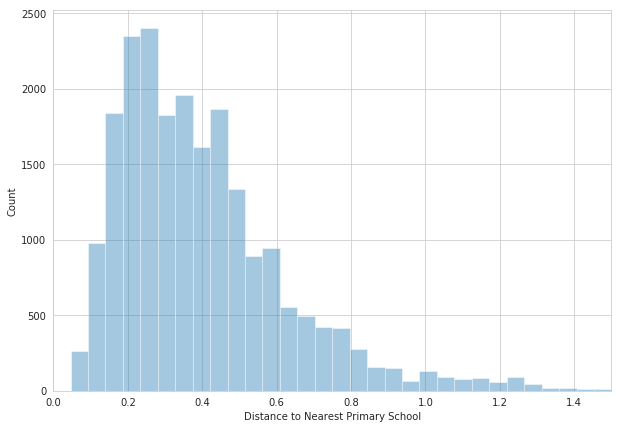

In [16]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

sns.distplot(houses['nearest_sch_primary_dist'], bins = 50,
             hist=True,kde=False)
ax.set_xlim(0,1.5)
ax.set_xlabel('Distance to Nearest Primary School')
ax.set_ylabel('Count')

plt.show()

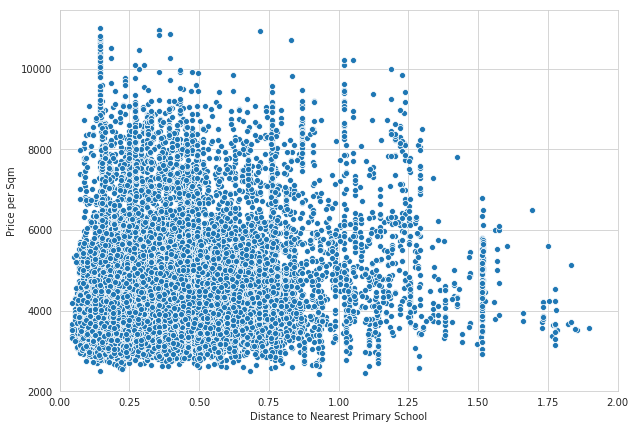

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

sns.scatterplot(houses['nearest_sch_primary_dist'], houses['price_per_sqm'])

ax.set_xlim( 0, 2)
ax.set_xlabel('Distance to Nearest Primary School')
ax.set_ylabel('Price per Sqm')

plt.show()

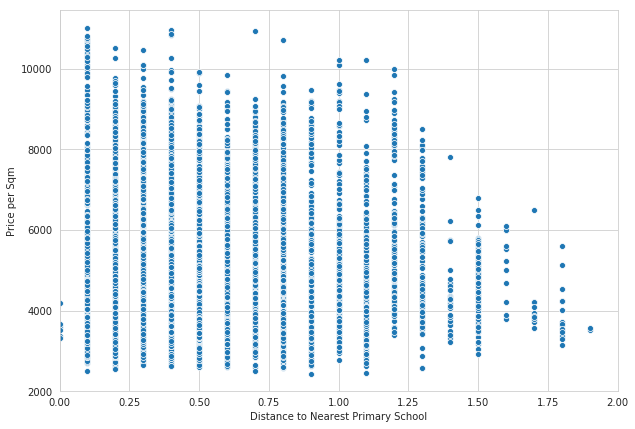

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

sns.scatterplot(round(houses['nearest_sch_primary_dist'],1), houses['price_per_sqm'])

ax.set_xlim( 0, 2)
ax.set_xlabel('Distance to Nearest Primary School')
ax.set_ylabel('Price per Sqm')

plt.show()

In [19]:
houses[['nearest_sch_primary_dist', 'price_per_sqm']].corr()

,nearest_sch_primary_dist,price_per_sqm
nearest_sch_primary_dist,1.00,0.12
price_per_sqm,0.12,1.00


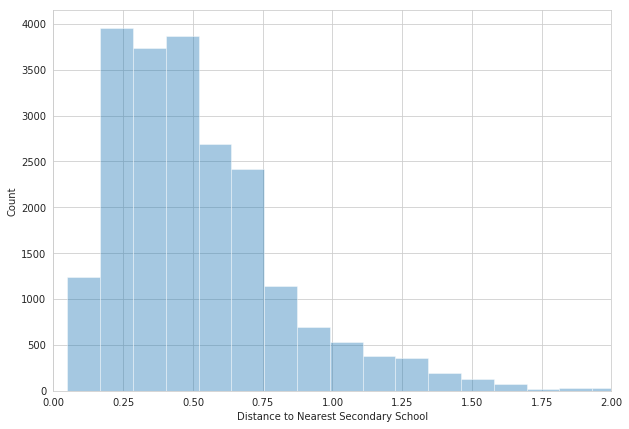

In [20]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

sns.distplot(houses['nearest_sch_secondary_dist'], bins = 30,
             hist=True,kde=False)
ax.set_xlim(0,2)
ax.set_xlabel('Distance to Nearest Secondary School')
ax.set_ylabel('Count')

plt.show()

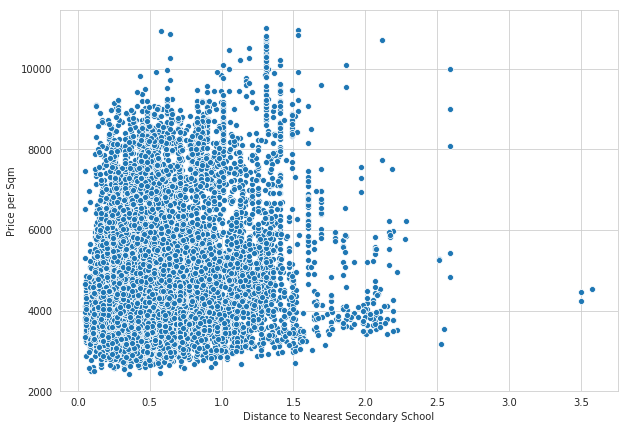

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

sns.scatterplot(houses['nearest_sch_secondary_dist'], houses['price_per_sqm'])

# ax.set_xlim( 0, 2)
ax.set_xlabel('Distance to Nearest Secondary School')
ax.set_ylabel('Price per Sqm')

plt.show()

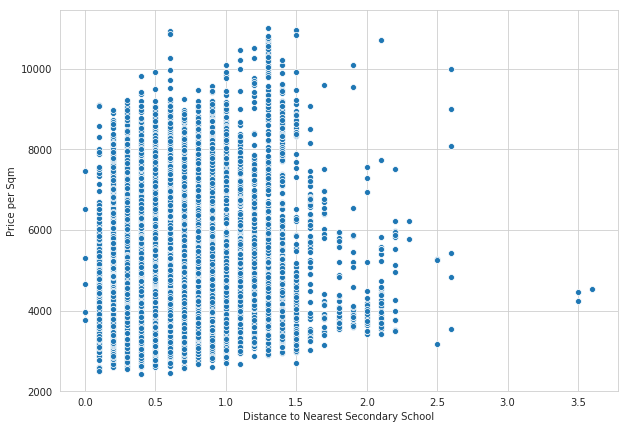

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

sns.scatterplot(round(houses['nearest_sch_secondary_dist'],1), houses['price_per_sqm'])

# ax.set_xlim( 0, 2)
ax.set_xlabel('Distance to Nearest Secondary School')
ax.set_ylabel('Price per Sqm')

plt.show()

In [23]:
houses[['nearest_sch_secondary_dist', 'price_per_sqm']].corr()

,nearest_sch_secondary_dist,price_per_sqm
nearest_sch_secondary_dist,1.00,0.21
price_per_sqm,0.21,1.00


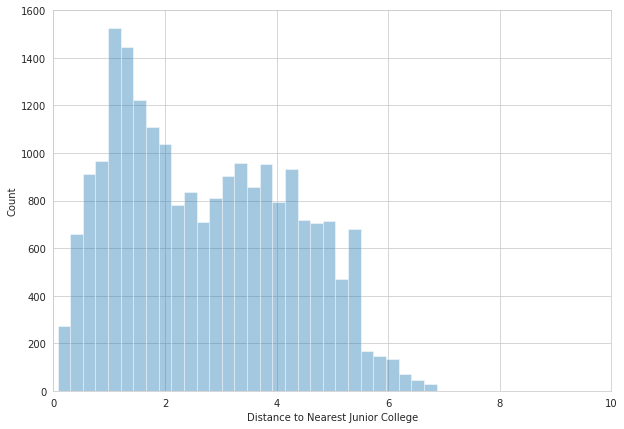

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

sns.distplot(houses['nearest_sch_juniorcollege_dist'], bins = 30,
             hist=True,kde=False)
ax.set_xlim(0,10)
ax.set_xlabel('Distance to Nearest Junior College')
ax.set_ylabel('Count')

plt.show()

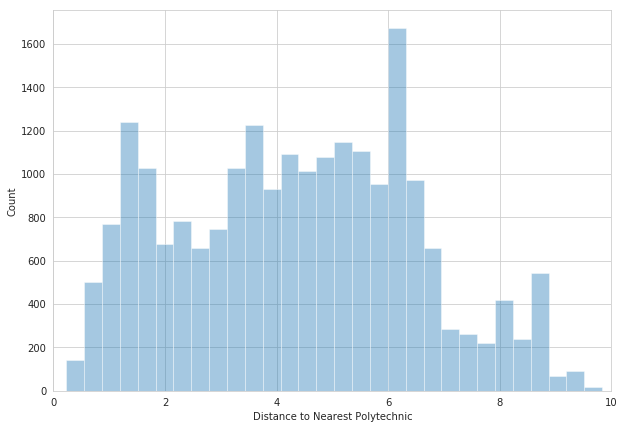

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

sns.distplot(houses['nearest_sch_polytechnic_dist'], bins = 30,
             hist=True,kde=False)
ax.set_xlim(0,10)
ax.set_xlabel('Distance to Nearest Polytechnic')
ax.set_ylabel('Count')

plt.show()

In [26]:
houses.columns.values

array(['month', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'remaining_lease', 'resale_price',
       'transaction_year', 'transaction_month', 'loc_lat', 'loc_lon',
       'nearest_mrt_name', 'nearest_mrt_dist', 'nearest_mrt_code',
       'nearest_mrt_line', 'nearest_mrt_lat', 'nearest_mrt_lon',
       'nearest_mrt_dist_centre', 'busstop1_name', 'busstop1_code',
       'busstop1_dist', 'busstop2_name', 'busstop2_code', 'busstop2_dist',
       'busstop3_name', 'busstop3_code', 'busstop3_dist',
       'nearest_sch_primary_name', 'nearest_sch_primary_address',
       'nearest_sch_primary_postalcode', 'nearest_sch_primary_lat',
       'nearest_sch_primary_lon', 'nearest_sch_primary_dist',
       'nearest_sch_primary_sap', 'nearest_sch_secondary_name',
       'nearest_sch_secondary_address',
       'nearest_sch_secondary_postalcode', 'nearest_sch_secondary_lat',
       'nearest_sch_secondary_lon', 'nearest

Questions:
1. what are the top 10 factors that affect resale price?
2. Is resale price affected by distance to nearest school?
- primary, secondary, junior college, polytechnic, university
3. Impact on MRT stations on resale price
- distance to nearest mrt
- MRT line of nearest mrt
4. Impact of 'dist to city centre' on resale price
5. Impact on floor height on resale price


In [27]:
##################################################
# Section 1: what are the top 10 factors that 
# affect resale price?
##################################################

In [28]:
##################################################
# Section 2: Is resale price affected by 
# distance to nearest school?
##################################################

In [29]:
##################################################
# Section 2a: any school
##################################################

In [30]:
##################################################
# Section 2b: primary, secondary
##################################################

In [31]:
##################################################
# Section 2a: primary, secondary, junior college, 
# polytechnic, university
##################################################

In [32]:
##################################################
# Section 2a: primary, secondary, junior college, 
# polytechnic, university
##################################################

In [33]:
##################################################
# Section 3a: Impact on MRT stations on resale price
##################################################

In [34]:
##################################################
# Section 3b: distance to nearest mrt
##################################################

In [35]:
##################################################
# Section 3c: MRT line of nearest mrt
##################################################

In [36]:
##################################################
# Section 4: Impact of 'dist to city centre' on 
# resale price
##################################################

In [37]:
##################################################
# Section 5: Impact on floor height on resale price
##################################################

In [38]:
##################################################
# Impact on flat_type on resale price
##################################################

In [39]:
houses.sample(10)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,flatmodel_modela2,flatmodel_types1,flatmodel_types2,flatmodel_premiummaisonette,flatmodel_terrace,flatmodel_modelamaisonette,flatmodel_improvedmaisonette,flatmodel_multigeneration,flatmodel_premiumapartmentloft,price_per_sqm
3806,2018-03,TAMPINES,5 ROOM,903,TAMPINES AVE 4,01 TO 03,134,Model A,1984,65,...,0,0,0,0,0,0,0,0,0,"4,141.79"
14149,2018-08,WOODLANDS,EXECUTIVE,804,WOODLANDS ST 81,04 TO 06,146,Maisonette,1988,69,...,0,0,0,0,0,0,0,0,0,"3,801.37"
14225,2018-08,YISHUN,4 ROOM,249,YISHUN AVE 9,10 TO 12,84,Simplified,1985,66,...,0,0,0,0,0,0,0,0,0,"3,583.33"
9269,2018-06,TAMPINES,4 ROOM,891A,TAMPINES AVE 8,10 TO 12,100,Model A,1997,77,...,0,0,0,0,0,0,0,0,0,"4,380.00"
16918,2018-10,GEYLANG,4 ROOM,121,PAYA LEBAR WAY,01 TO 03,91,New Generation,1980,60,...,0,0,0,0,0,0,0,0,0,"3,901.10"
4378,2018-04,BUKIT BATOK,3 ROOM,265,BT BATOK EAST AVE 4,10 TO 12,82,New Generation,1985,66,...,0,0,0,0,0,0,0,0,0,"3,536.59"
5674,2018-04,TAMPINES,EXECUTIVE,334,TAMPINES ST 32,01 TO 03,148,Apartment,1996,76,...,0,0,0,0,0,0,0,0,0,"3,716.22"
16457,2018-10,BEDOK,5 ROOM,118,BEDOK NTH ST 2,07 TO 09,123,Standard,1978,58,...,0,0,0,0,0,0,0,0,0,"4,105.69"
20618,2018-12,GEYLANG,4 ROOM,111,ALJUNIED CRES,04 TO 06,92,New Generation,1978,58,...,0,0,0,0,0,0,0,0,0,"4,782.61"
15216,2018-09,JURONG WEST,5 ROOM,272D,JURONG WEST ST 24,10 TO 12,112,Premium Apartment,2003,84,...,0,0,0,0,0,0,0,0,0,"3,214.29"


Text(0.5, 1.0, 'Flat Type vs Resale Price')

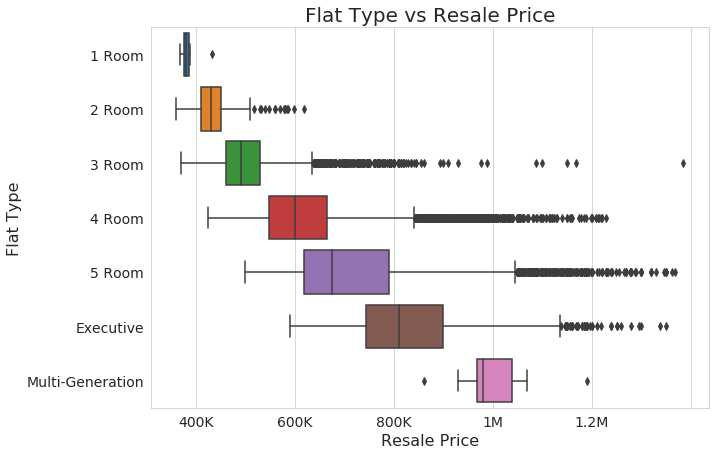

In [40]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='resale_price',y='flat_type', data=houses,
           order = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM',
                    '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION'])

ax.set_xticklabels(['200K','400K','600K','800K','1M','1.2M'],
                  fontsize=14)
ax.set_xlabel('Resale Price', fontsize=16)
ax.set_yticklabels( ['1 Room', '2 Room', '3 Room', '4 Room',
                    '5 Room', 'Executive', 'Multi-Generation'],
                   fontsize=14)
ax.set_ylabel('Flat Type', fontsize=16)
ax.set_title('Flat Type vs Resale Price', fontsize=20)

In [41]:
houses[ (houses.flat_type=='3 ROOM') & 
       (houses.resale_price > 700000)][['town','flat_type','block','street_name',
                                       'storey_range','floor_area_sqm','flat_model',
                                       'resale_price']]


,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,resale_price
509,KALLANG/WHAMPOA,3 ROOM,63,JLN MA'MOR,01 TO 03,116,Terrace,788000
1636,KALLANG/WHAMPOA,3 ROOM,52,JLN BAHAGIA,01 TO 03,141,Terrace,900000
6768,KALLANG/WHAMPOA,3 ROOM,44,JLN BAHAGIA,01 TO 03,185,Terrace,968000
8707,KALLANG/WHAMPOA,3 ROOM,46,JLN BAHAGIA,01 TO 03,93,Terrace,730000
8710,KALLANG/WHAMPOA,3 ROOM,58,JLN MA'MOR,01 TO 03,174,Terrace,950000
13489,QUEENSTOWN,3 ROOM,55,STIRLING RD,01 TO 03,87,Terrace,888000
15269,KALLANG/WHAMPOA,3 ROOM,41,JLN BAHAGIA,01 TO 03,237,Terrace,1185000
17243,KALLANG/WHAMPOA,3 ROOM,38,JLN BAHAGIA,01 TO 03,83,Terrace,710000
19145,KALLANG/WHAMPOA,3 ROOM,40,JLN BAHAGIA,01 TO 03,91,Terrace,775000


In [42]:
# there are 3 rooms are high prices: e.g. 57 Jln Mamor @ $1.15M
# on a closer look, these high prices 3-rooms are 'Terrace'

In [43]:
##################################################
# Impact on flat_type on price per sqm
##################################################

Text(0.5, 1.0, 'Flat Type vs Price per Square Metre')

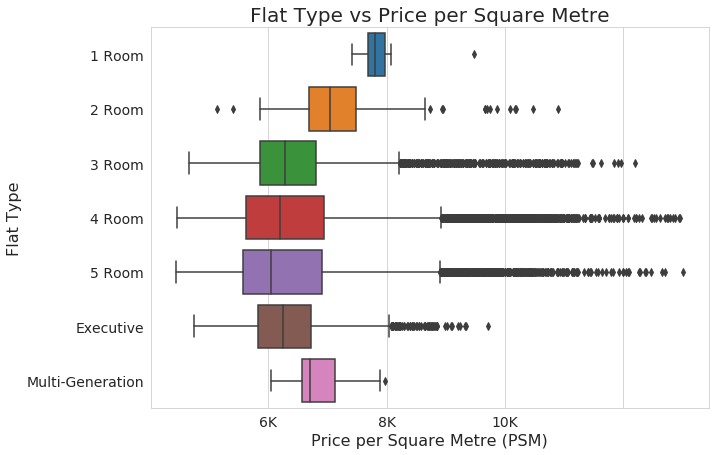

In [44]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='price_per_sqm',y='flat_type', data=houses,
           order = ['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM',
                    '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION'])

ax.set_xticklabels(['4K','6K','8K','10K'],
                  fontsize=14)
ax.set_xlabel('Price per Square Metre (PSM)', fontsize=16)
ax.set_yticklabels( ['1 Room', '2 Room', '3 Room', '4 Room',
                    '5 Room', 'Executive', 'Multi-Generation'],
                   fontsize=14)
ax.set_ylabel('Flat Type', fontsize=16)
ax.set_title('Flat Type vs Price per Square Metre', fontsize=20)


Text(0.5, 1.0, '2 Room')

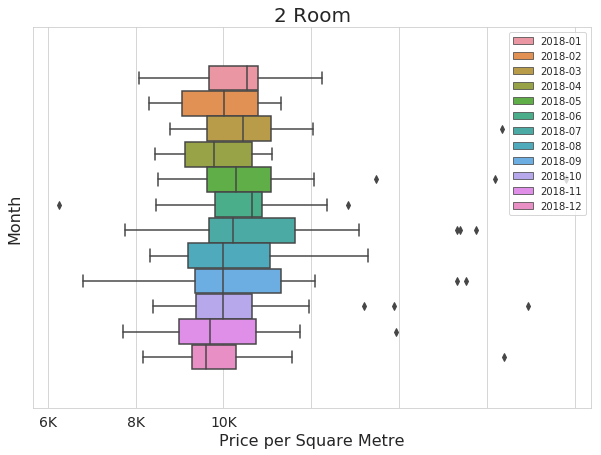

In [45]:
##################################################
# Impact on month on resale price
##################################################

fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='price_per_sqm',y='flat_type', 
            data=houses[(houses.flat_type=='2 ROOM')],
            hue='month')
ax.legend(loc=1)

ax.set_xticklabels(['4K','6K','8K','10K'],
                  fontsize=14)
ax.set_xlabel('Price per Square Metre', fontsize=16)
ax.set_yticklabels('',fontsize=14)
ax.set_ylabel('Month', fontsize=16)
ax.set_title('2 Room', fontsize = 20)

Text(0.5, 1.0, '3 Room')

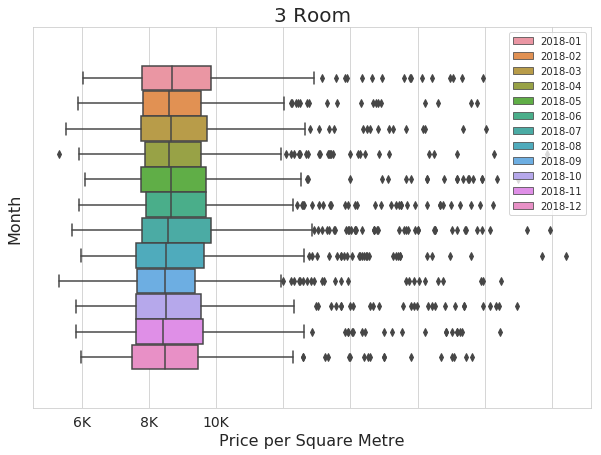

In [46]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='price_per_sqm',y='flat_type', 
            data=houses[(houses.flat_type=='3 ROOM')],
            hue='month')
ax.legend(loc=1)

ax.set_xticklabels(['4K','6K','8K','10K'],
                  fontsize=14)
ax.set_xlabel('Price per Square Metre', fontsize=16)
ax.set_yticklabels('',fontsize=14)
ax.set_ylabel('Month', fontsize=16)
ax.set_title('3 Room', fontsize = 20)

Text(0.5, 1.0, '4 Room')

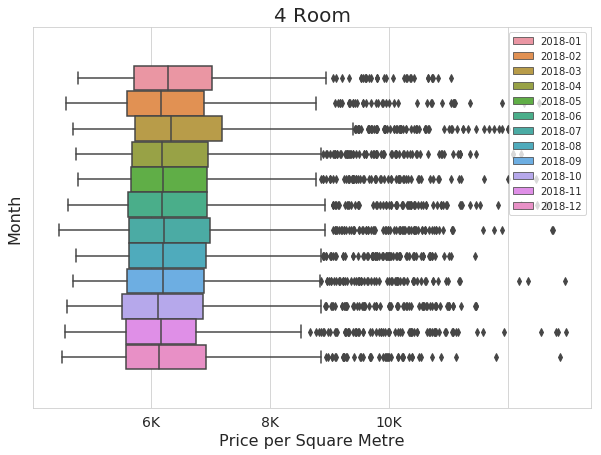

In [47]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='price_per_sqm',y='flat_type', 
            data=houses[(houses.flat_type=='4 ROOM')],
            hue='month')
ax.legend(loc=1)

ax.set_xticklabels(['4K','6K','8K','10K'],
                  fontsize=14)
ax.set_xlabel('Price per Square Metre', fontsize=16)
ax.set_yticklabels('',fontsize=14)
ax.set_ylabel('Month', fontsize=16)
ax.set_title('4 Room', fontsize = 20)

Text(0.5, 1.0, '5 Room')

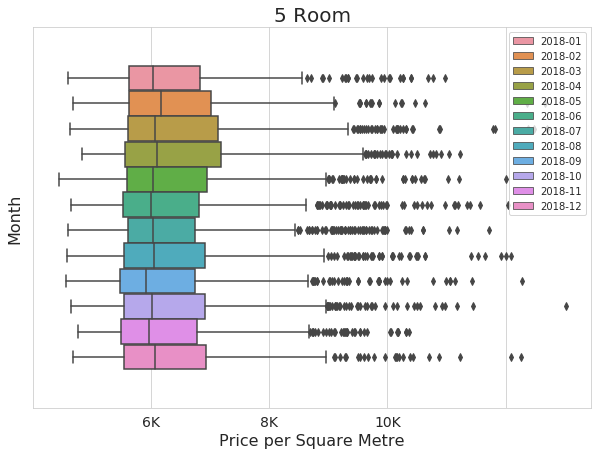

In [48]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='price_per_sqm',y='flat_type', 
            data=houses[(houses.flat_type=='5 ROOM')],
            hue='month')
ax.legend(loc=1)

ax.set_xticklabels(['4K','6K','8K','10K'],
                  fontsize=14)
ax.set_xlabel('Price per Square Metre', fontsize=16)
ax.set_yticklabels('',fontsize=14)
ax.set_ylabel('Month', fontsize=16)
ax.set_title('5 Room', fontsize = 20)

Text(0.5, 1.0, 'Executive')

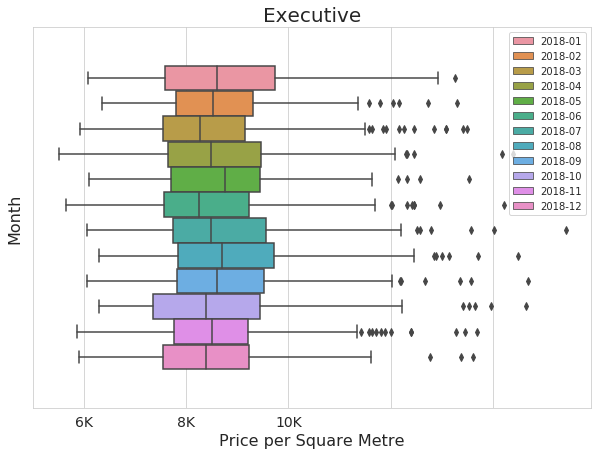

In [49]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='price_per_sqm',y='flat_type', 
            data=houses[(houses.flat_type=='EXECUTIVE')],
            hue='month')
ax.legend(loc=1)

ax.set_xticklabels(['4K','6K','8K','10K'],
                  fontsize=14)
ax.set_xlabel('Price per Square Metre', fontsize=16)
ax.set_yticklabels('',fontsize=14)
ax.set_ylabel('Month', fontsize=16)
ax.set_title('Executive', fontsize = 20)

Text(0.5, 1.0, 'Multi-Generation')

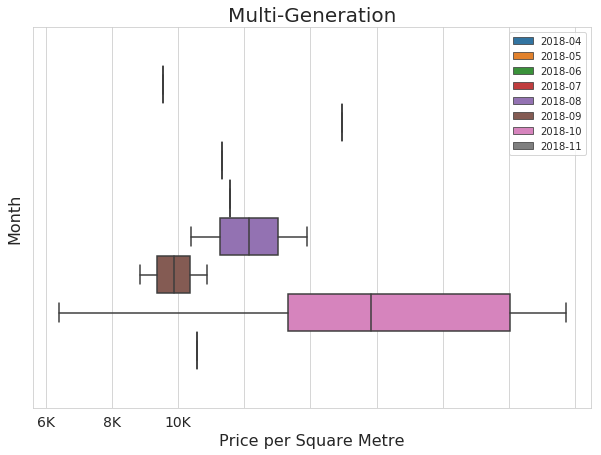

In [50]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='price_per_sqm',y='flat_type', 
            data=houses[(houses.flat_type=='MULTI-GENERATION')],
            hue='month')
ax.legend(loc=1)

ax.set_xticklabels(['4K','6K','8K','10K'],
                  fontsize=14)
ax.set_xlabel('Price per Square Metre', fontsize=16)
ax.set_yticklabels('',fontsize=14)
ax.set_ylabel('Month', fontsize=16)
ax.set_title('Multi-Generation', fontsize = 20)

In [51]:
temp = houses[ (houses['flat_type'] == '2 ROOM') |
               (houses['flat_type'] == '3 ROOM') |
               (houses['flat_type'] == '4 ROOM') |
               (houses['flat_type'] == '5 ROOM') |              
               (houses['flat_type'] == 'EXECUTIVE') 
             ]

temp[['transaction_month','price_per_sqm']].corr()

,transaction_month,price_per_sqm
transaction_month,1.00,-0.03
price_per_sqm,-0.03,1.00


In [52]:
##################################################
# Impact on flat model on resale price
##################################################

# fig, ax = plt.subplots(figsize=(10,7))
# sns.boxplot(x='resale_price',y='flat_model', data=houses)

In [53]:
# fig, ax = plt.subplots(figsize=(12,8))
# sns.boxplot(x='resale_price', y='flat_model', 
#             data=houses[(houses.flat_model=='Improved') |
#                         (houses.flat_model=='Generation') |
#                         (houses.flat_model=='Model A') |
#                         (houses.flat_model=='DBSS') |
#                         (houses.flat_model=='Simplified')],
#             hue='flat_type')

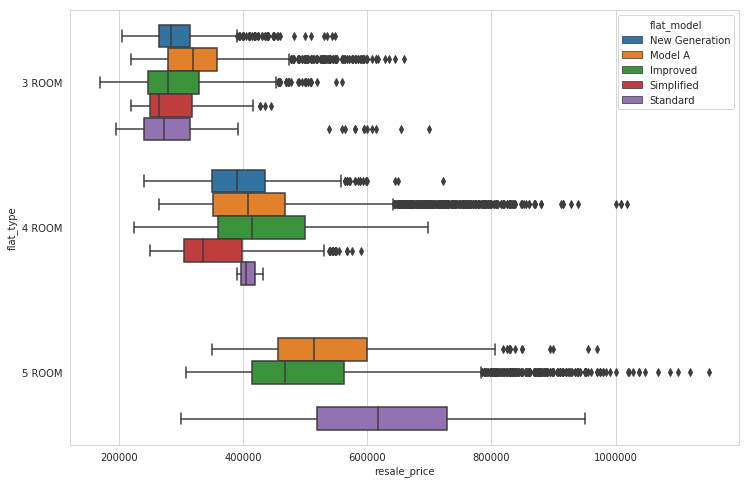

In [54]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='resale_price', y='flat_type', 
            data=houses[((houses['flat_type']=='3 ROOM') | 
                        (houses['flat_type']=='4 ROOM') | 
                        (houses['flat_type']=='5 ROOM')   ) &
                        ((houses['flat_model'] == 'New Generation') |
                         (houses['flat_model'] == 'Model A') |
                         (houses['flat_model'] == 'Improved') |
                         (houses['flat_model'] == 'Simplified') |
                         (houses['flat_model'] == 'Standard')   )
                       ],
            hue='flat_model')

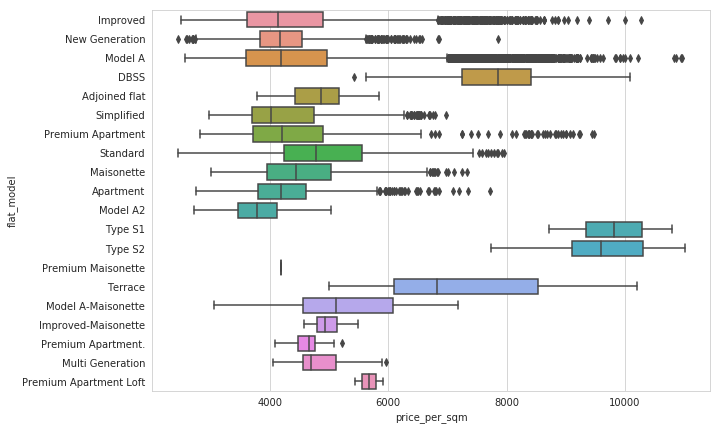

In [55]:
##################################################
# Impact of flat model on price per sqm
##################################################

fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(x='price_per_sqm',y='flat_model', data=houses)

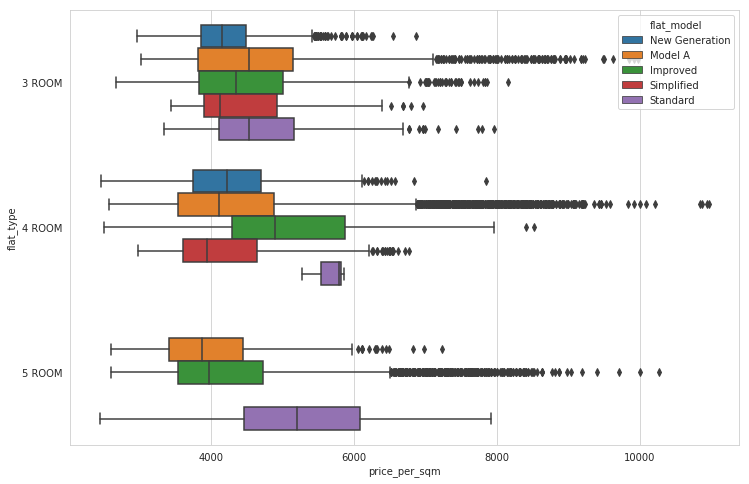

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='price_per_sqm', y='flat_type', 
            data=houses[((houses['flat_type']=='3 ROOM') | 
                        (houses['flat_type']=='4 ROOM') | 
                        (houses['flat_type']=='5 ROOM')   ) &
                        ((houses['flat_model'] == 'New Generation') |
                         (houses['flat_model'] == 'Model A') |
                         (houses['flat_model'] == 'Improved') |
                         (houses['flat_model'] == 'Simplified') |
                         (houses['flat_model'] == 'Standard')   )
                       ],
            hue='flat_model')

In [57]:
##################################################
# Impact of remaining lease on price per sqm
##################################################

Text(0.5, 1.0, 'EXECUTIVE')

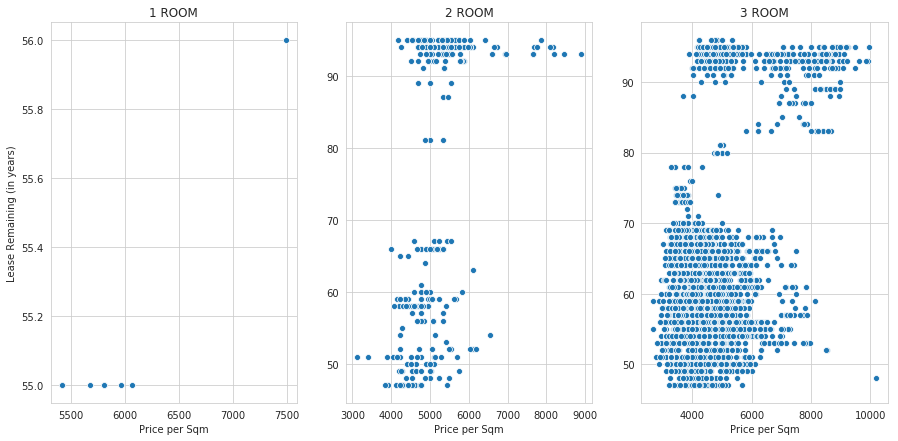

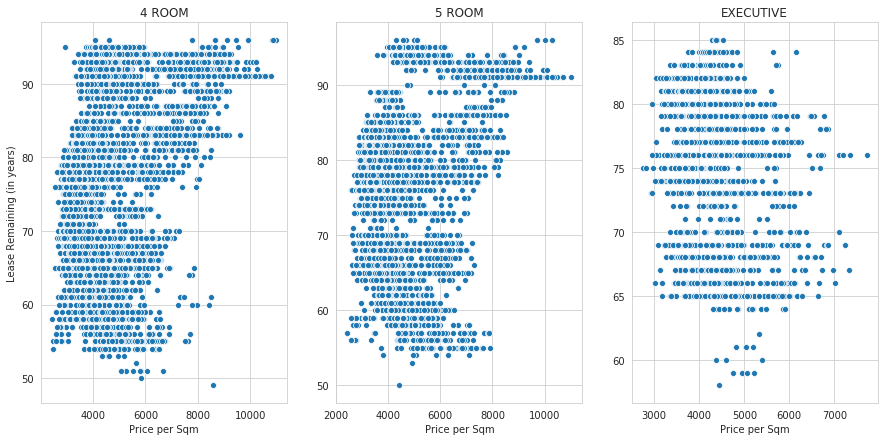

In [58]:
fig, ax = plt.subplots(1,3, figsize=(15,7))
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[houses.flat_type=='1 ROOM'], 
                ax=ax[0])

sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[houses.flat_type=='2 ROOM'], 
                ax=ax[1])
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[houses.flat_type=='3 ROOM'], 
                 ax=ax[2])


# ax[0].set_ylim([-100, 2250])
ax[0].set_xlabel('Price per Sqm')
ax[0].set_ylabel('Lease Remaining (in years)')
ax[0].set_title('1 ROOM')
ax[1].set_xlabel('Price per Sqm')
ax[1].set_ylabel('')
ax[1].set_title('2 ROOM')
ax[2].set_xlabel('Price per Sqm')
ax[2].set_ylabel('')
ax[2].set_title('3 ROOM')

fig, ax = plt.subplots(1,3, figsize=(15,7))
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='4 ROOM')], 
                 ax=ax[0])

sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[houses.flat_type=='5 ROOM'], 
                 ax=ax[1])
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[houses.flat_type=='EXECUTIVE'], 
                 ax=ax[2])


# ax[0].set_ylim([-100, 2250])
ax[0].set_xlabel('Price per Sqm')
ax[0].set_ylabel('Lease Remaining (in years)')
ax[0].set_title('4 ROOM')
ax[1].set_xlabel('Price per Sqm')
ax[1].set_ylabel('')
ax[1].set_title('5 ROOM')
ax[2].set_xlabel('Price per Sqm')
ax[2].set_ylabel('')
ax[2].set_title('EXECUTIVE')

[Text(0, 0, '4K'), Text(0, 0, '6K'), Text(0, 0, '8K'), Text(0, 0, '10K')]

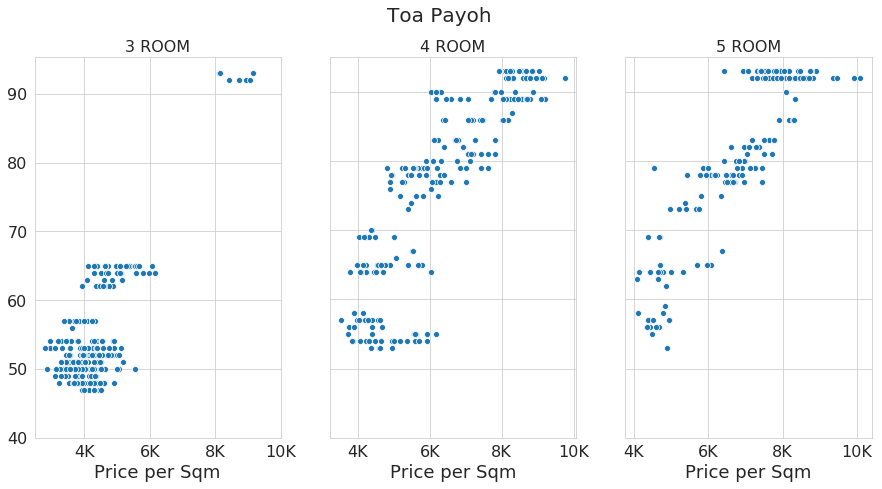

In [149]:
fig, ax = plt.subplots(1,3, figsize=(15,7))
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='3 ROOM') &
                            (houses.town=='TOA PAYOH')], 
                ax=ax[0])
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='4 ROOM') &
                            (houses.town=='TOA PAYOH')], 
                ax=ax[1])
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='5 ROOM') &
                            (houses.town=='TOA PAYOH')], 
                ax=ax[2])



fig.suptitle('Toa Payoh', fontsize=20)

ax[0].set_xlabel('Price per Sqm', fontsize=18)
ax[0].set_ylabel('')
ax[0].set_title('3 ROOM', fontsize=16)
ax[0].set_yticklabels([40,50,60,70,80,90], fontsize=16)
ax[0].set_yticks(np.arange(40,100,step=10))
ax[0].set_xticks(np.arange(4000,12000,step=2000))
ax[0].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


ax[1].set_xlabel('Price per Sqm', fontsize=18)
ax[1].set_ylabel('')
ax[1].set_title('4 ROOM', fontsize=16)
ax[1].set_yticklabels('', fontsize=16)
ax[1].set_yticks(np.arange(40,100,step=10))
ax[1].set_xticks(np.arange(4000,12000,step=2000))
ax[1].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


ax[2].set_xlabel('Price per Sqm', fontsize=18)
ax[2].set_ylabel('')
ax[2].set_title('5 ROOM', fontsize=16)
ax[2].set_yticklabels('', fontsize=16)
ax[2].set_yticks(np.arange(40,100,step=10))
ax[2].set_xticks(np.arange(4000,12000,step=2000))
ax[2].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


[Text(0, 0, '4K'), Text(0, 0, '6K'), Text(0, 0, '8K'), Text(0, 0, '10K')]

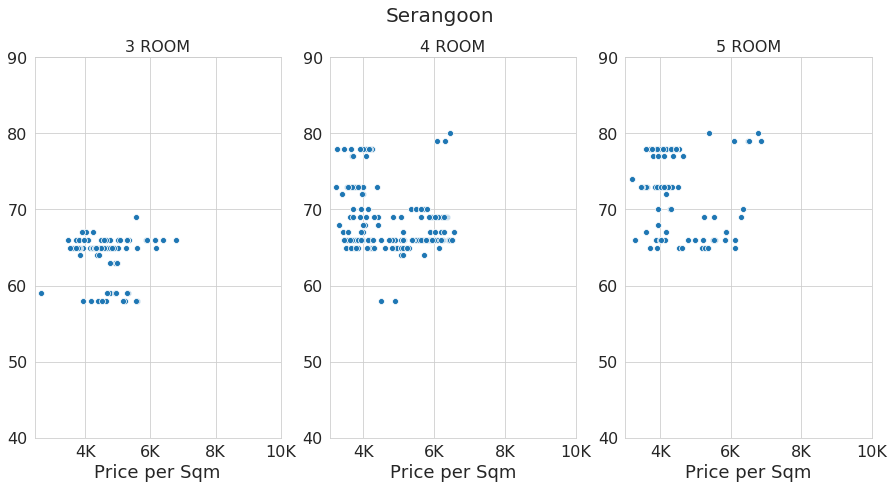

In [60]:
fig, ax = plt.subplots(1,3, figsize=(15,7))
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='3 ROOM') &
                            (houses.town=='SERANGOON')], 
                ax=ax[0])
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='4 ROOM') &
                            (houses.town=='SERANGOON')], 
                ax=ax[1])
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='5 ROOM') &
                            (houses.town=='SERANGOON')], 
                ax=ax[2])



fig.suptitle('Serangoon', fontsize=20)

ax[0].set_xlabel('Price per Sqm', fontsize=18)
ax[0].set_ylabel('')
ax[0].set_title('3 ROOM', fontsize=16)
ax[0].set_yticklabels([40,50,60,70,80,90], fontsize=16)
ax[0].set_yticks(np.arange(40,100,step=10))
ax[0].set_xticks(np.arange(4000,12000,step=2000))
ax[0].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


ax[1].set_xlabel('Price per Sqm', fontsize=18)
ax[1].set_ylabel('')
ax[1].set_title('4 ROOM', fontsize=16)
ax[1].set_yticklabels([40,50,60,70,80,90], fontsize=16)
ax[1].set_yticks(np.arange(40,100,step=10))
ax[1].set_xticks(np.arange(4000,12000,step=2000))
ax[1].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


ax[2].set_xlabel('Price per Sqm', fontsize=18)
ax[2].set_ylabel('')
ax[2].set_title('5 ROOM', fontsize=16)
ax[2].set_yticklabels([40,50,60,70,80,90], fontsize=16)
ax[2].set_yticks(np.arange(40,100,step=10))
ax[2].set_xticks(np.arange(4000,12000,step=2000))
ax[2].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


[Text(0, 0, '4K'), Text(0, 0, '6K'), Text(0, 0, '8K'), Text(0, 0, '10K')]

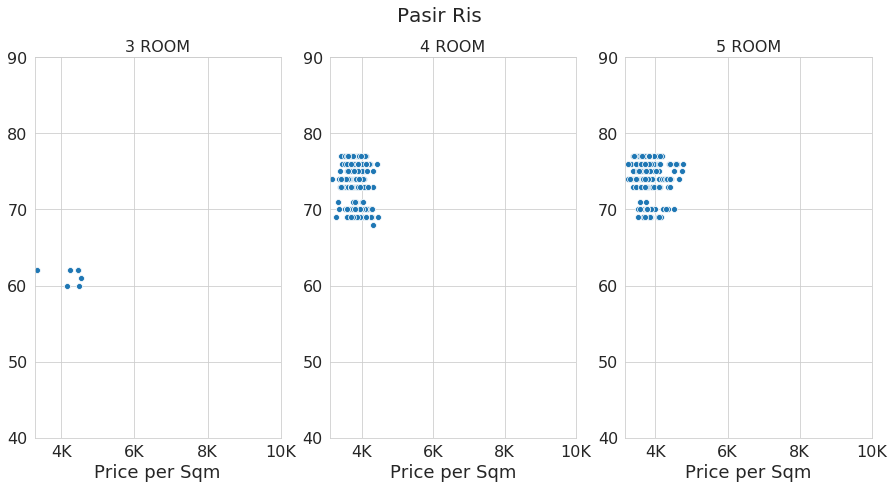

In [61]:
fig, ax = plt.subplots(1,3, figsize=(15,7))
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='3 ROOM') &
                            (houses.town=='PASIR RIS')], 
                ax=ax[0])
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='4 ROOM') &
                            (houses.town=='PASIR RIS')], 
                ax=ax[1])
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='5 ROOM') &
                            (houses.town=='PASIR RIS')], 
                ax=ax[2])



fig.suptitle('Pasir Ris', fontsize=20)

ax[0].set_xlabel('Price per Sqm', fontsize=18)
ax[0].set_ylabel('')
ax[0].set_title('3 ROOM', fontsize=16)
ax[0].set_yticklabels([40,50,60,70,80,90], fontsize=16)
ax[0].set_yticks(np.arange(40,100,step=10))
ax[0].set_xticks(np.arange(4000,12000,step=2000))
ax[0].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


ax[1].set_xlabel('Price per Sqm', fontsize=18)
ax[1].set_ylabel('')
ax[1].set_title('4 ROOM', fontsize=16)
ax[1].set_yticklabels([40,50,60,70,80,90], fontsize=16)
ax[1].set_yticks(np.arange(40,100,step=10))
ax[1].set_xticks(np.arange(4000,12000,step=2000))
ax[1].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


ax[2].set_xlabel('Price per Sqm', fontsize=18)
ax[2].set_ylabel('')
ax[2].set_title('5 ROOM', fontsize=16)
ax[2].set_yticklabels([40,50,60,70,80,90], fontsize=16)
ax[2].set_yticks(np.arange(40,100,step=10))
ax[2].set_xticks(np.arange(4000,12000,step=2000))
ax[2].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


[Text(0, 0, '4K'), Text(0, 0, '6K'), Text(0, 0, '8K'), Text(0, 0, '10K')]

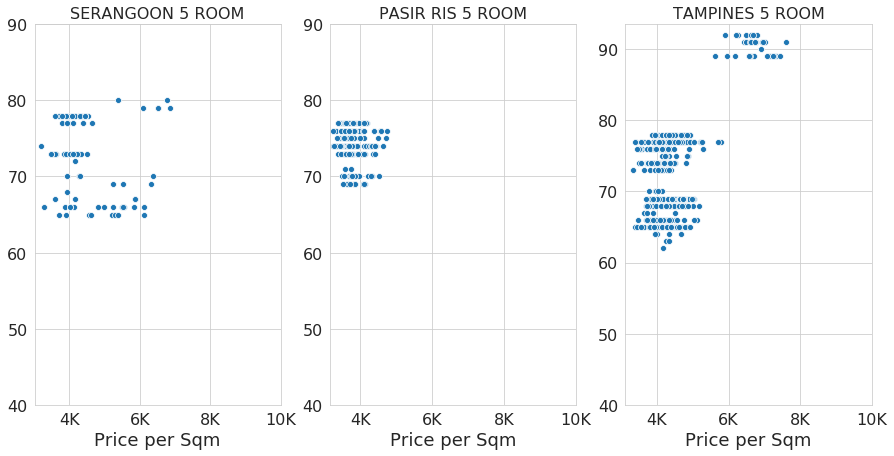

In [62]:
fig, ax = plt.subplots(1,3, figsize=(15,7))
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='5 ROOM') &
                            (houses.town=='SERANGOON')], 
                ax=ax[0])
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='5 ROOM') &
                            (houses.town=='PASIR RIS')], 
                ax=ax[1])
sns.scatterplot(x='price_per_sqm',y='remaining_lease', 
                data=houses[(houses.flat_type=='5 ROOM') &
                            (houses.town=='TAMPINES')], 
                ax=ax[2])


ax[0].set_xlabel('Price per Sqm', fontsize=18)
ax[0].set_ylabel('')
ax[0].set_title('SERANGOON 5 ROOM', fontsize=16)
ax[0].set_yticklabels([40,50,60,70,80,90], fontsize=16)
ax[0].set_yticks(np.arange(40,100,step=10))
ax[0].set_xticks(np.arange(4000,12000,step=2000))
ax[0].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


ax[1].set_xlabel('Price per Sqm', fontsize=18)
ax[1].set_ylabel('')
ax[1].set_title('PASIR RIS 5 ROOM', fontsize=16)
ax[1].set_yticklabels([40,50,60,70,80,90], fontsize=16)
ax[1].set_yticks(np.arange(40,100,step=10))
ax[1].set_xticks(np.arange(4000,12000,step=2000))
ax[1].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


ax[2].set_xlabel('Price per Sqm', fontsize=18)
ax[2].set_ylabel('')
ax[2].set_title('TAMPINES 5 ROOM', fontsize=16)
ax[2].set_yticklabels([40,50,60,70,80,90], fontsize=16)
ax[2].set_yticks(np.arange(40,100,step=10))
ax[2].set_xticks(np.arange(4000,12000,step=2000))
ax[2].set_xticklabels(['4K','6K','8K','10K'], fontsize=16)


In [63]:
# storng: Toa Payoh, Punggol, Woodlands, Bukit Merah
# weak: pasir ris , bukit batok

In [64]:
# heat map for cols remaining lease vs price per sqm : by town

[Text(0, 0, '0.0'),
 Text(0, 0, '0.1'),
 Text(0, 0, '0.2'),
 Text(0, 0, '0.3'),
 Text(0, 0, '0.4'),
 Text(0, 0, '0.5')]

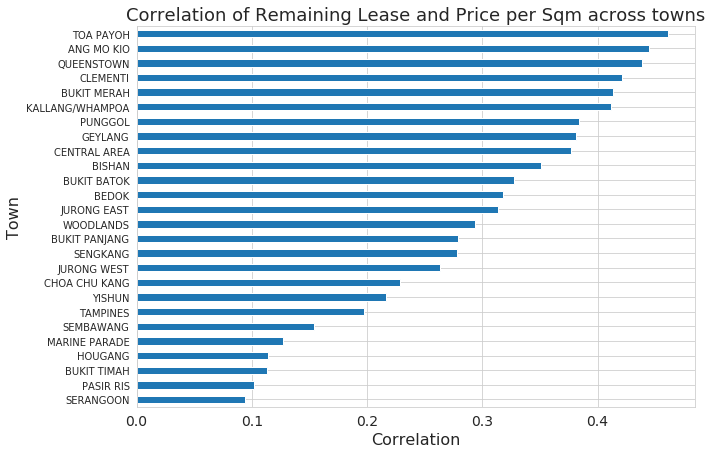

In [65]:
houses345 = houses[(houses.flat_type == '3 ROOM') | 
                   (houses.flat_type == '4 ROOM') | 
                   (houses.flat_type == '5 ROOM') ]

corr_345 = pd.DataFrame()

for town in houses345.town.unique():
    temp = houses345[houses345.town == town]
    corr_345 = corr_345.append([[town, temp.corr()['remaining_lease']['price_per_sqm']]])

corr_345.set_index(0, inplace=True)

corr_345['abs_corr'] = corr_345[1].map(lambda x: np.abs(x))
corr_345.sort_values(by='abs_corr', ascending=True, inplace=True)
corr_345.drop(columns=1, inplace=True)
fig, ax = plt.subplots(1,1,figsize=(10,7))
corr_345.plot(kind='barh', ax=ax, legend = False)
ax = fig.gca()
ax.set_ylabel('Town', fontsize=16)
ax.set_xlabel('Correlation', fontsize=16)
ax.set_title('Correlation of Remaining Lease and Price per Sqm across towns', fontsize=18)
ax.set_xticklabels([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], fontsize=14)

In [66]:
# scatter plot: school dist vs price per sqm

In [67]:
houses['nearest_PriAndSec_dist'] = 0.0
houses['nearest_PriOrSec_dist'] = 0.0

for index in houses.index:
    houses.loc[index, 'nearest_PriOrSec_dist'] = min(houses.loc[index,'nearest_sch_primary_dist'],
                                                     houses.loc[index,'nearest_sch_secondary_dist'])
    houses.loc[index, 'nearest_PriAndSec_dist'] = max(houses.loc[index,'nearest_sch_primary_dist'],
                                                     houses.loc[index,'nearest_sch_secondary_dist'])

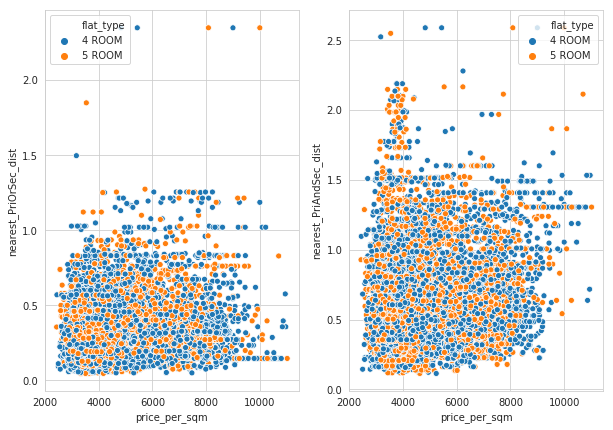

In [68]:
fig, ax = plt.subplots(1,2, figsize=(10,7))
sns.scatterplot(x='price_per_sqm',y='nearest_PriOrSec_dist', 
                data=houses[ (houses.flat_type=='4 ROOM') |
                             (houses.flat_type=='5 ROOM')], 
                hue = 'flat_type', ax=ax[0])
sns.scatterplot(x='price_per_sqm',y='nearest_PriAndSec_dist', 
                data=houses[ (houses.flat_type=='4 ROOM') |
                             (houses.flat_type=='5 ROOM')], 
                hue = 'flat_type', ax=ax[1])

[Text(0, 0, '2K'),
 Text(0, 0, '4K'),
 Text(0, 0, '6K'),
 Text(0, 0, '8K'),
 Text(0, 0, '10K'),
 Text(0, 0, '12K')]

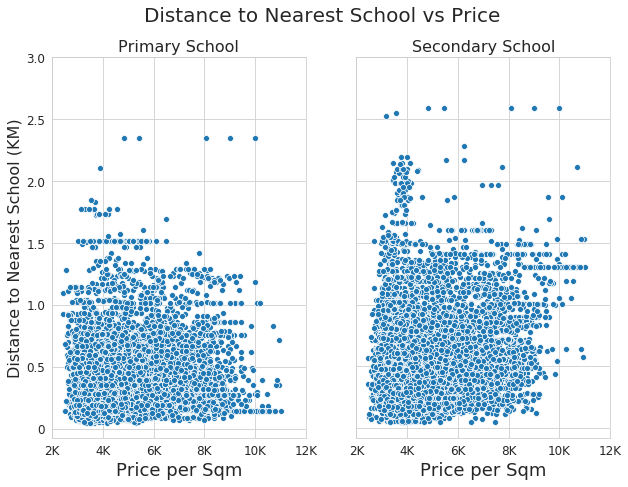

In [69]:
fig, ax = plt.subplots(1,2, figsize=(10,7))
sns.scatterplot(x='price_per_sqm',y='nearest_sch_primary_dist', 
                data=houses[ (houses.flat_type=='4 ROOM') |
                             (houses.flat_type=='5 ROOM')], 
                ax=ax[0])

sns.scatterplot(x='price_per_sqm',y='nearest_sch_secondary_dist', 
                data=houses[ (houses.flat_type=='4 ROOM') |
                             (houses.flat_type=='5 ROOM')], 
                ax=ax[1])

fig.suptitle('Distance to Nearest School vs Price', fontsize=20)

ax[0].set_xlabel('Price per Sqm', fontsize=18)
ax[0].set_ylabel('Distance to Nearest School (KM)', fontsize=16)
ax[0].set_title('Primary School', fontsize=16)
ax[0].set_yticklabels([0,0.5,1.0,1.5,2.0,2.5, 3.0], fontsize=12)
ax[0].set_yticks(np.arange(0,3.5,step=0.5))
ax[0].set_xticks(np.arange(2000,14000,step=2000))
ax[0].set_xticklabels(['2K','4K','6K','8K','10K','12K'], fontsize=12)

ax[1].set_xlabel('Price per Sqm', fontsize=18)
ax[1].set_title('Secondary School', fontsize=16)
ax[1].set_yticks(np.arange(0,3.5,step=0.5))
ax[1].set_yticklabels('')
ax[1].set_ylabel('')
ax[1].set_xticks(np.arange(2000,14000,step=2000))
ax[1].set_xticklabels(['2K','4K','6K','8K','10K','12K'], fontsize=12)



In [70]:
houses[ (houses.flat_type=='4 ROOM') |
        (houses.flat_type=='5 ROOM')][['price_per_sqm',
                                       'nearest_sch_primary_dist']].corr()


,price_per_sqm,nearest_sch_primary_dist
price_per_sqm,1.00,0.14
nearest_sch_primary_dist,0.14,1.00


In [71]:
houses[ (houses.flat_type=='4 ROOM') |
        (houses.flat_type=='5 ROOM')][['price_per_sqm',
                                       'nearest_sch_secondary_dist']].corr()


,price_per_sqm,nearest_sch_secondary_dist
price_per_sqm,1.00,0.23
nearest_sch_secondary_dist,0.23,1.00


[Text(0, 0, '2K'),
 Text(0, 0, '4K'),
 Text(0, 0, '6K'),
 Text(0, 0, '8K'),
 Text(0, 0, '10K'),
 Text(0, 0, '12K')]

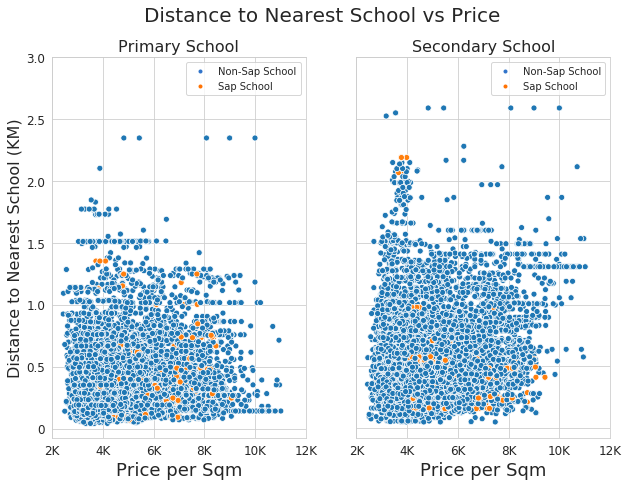

In [72]:
fig, ax = plt.subplots(1,2, figsize=(10,7))
sns.scatterplot(x='price_per_sqm',y='nearest_sch_primary_dist', 
                data=houses[ (houses.flat_type=='4 ROOM') |
                             (houses.flat_type=='5 ROOM')], 
                hue = 'nearest_sch_primary_sap', ax=ax[0])

sns.scatterplot(x='price_per_sqm',y='nearest_sch_secondary_dist', 
                data=houses[ (houses.flat_type=='4 ROOM') |
                             (houses.flat_type=='5 ROOM')], 
                hue = 'nearest_sch_secondary_sap', ax=ax[1])



custom = [Line2D([], [], marker='.', color='#2F73CA', linestyle='None'),
          Line2D([], [], marker='.', color='#FF7100', linestyle='None')]

ax[0].legend(custom, ['Non-Sap School', 'Sap School'], loc=1)
ax[1].legend(custom, ['Non-Sap School', 'Sap School'], loc=1)


fig.suptitle('Distance to Nearest School vs Price', fontsize=20)

ax[0].set_xlabel('Price per Sqm', fontsize=18)
ax[0].set_ylabel('Distance to Nearest School (KM)', fontsize=16)
ax[0].set_title('Primary School', fontsize=16)
ax[0].set_yticklabels([0,0.5,1.0,1.5,2.0,2.5, 3.0], fontsize=12)
ax[0].set_yticks(np.arange(0,3.5,step=0.5))
ax[0].set_xticks(np.arange(2000,14000,step=2000))
ax[0].set_xticklabels(['2K','4K','6K','8K','10K','12K'], fontsize=12)

ax[1].set_xlabel('Price per Sqm', fontsize=18)
ax[1].set_title('Secondary School', fontsize=16)
ax[1].set_yticks(np.arange(0,3.5,step=0.5))
ax[1].set_yticklabels('')
ax[1].set_ylabel('')
ax[1].set_xticks(np.arange(2000,14000,step=2000))
ax[1].set_xticklabels(['2K','4K','6K','8K','10K','12K'], fontsize=12)


In [73]:
houses[ (houses.flat_type=='4 ROOM') |
        (houses.flat_type=='5 ROOM')][['price_per_sqm',
                                       'nearest_sch_primary_sap']].corr()


,price_per_sqm,nearest_sch_primary_sap
price_per_sqm,1.00,0.09
nearest_sch_primary_sap,0.09,1.00


In [74]:
houses[ (houses.flat_type=='4 ROOM') |
        (houses.flat_type=='5 ROOM')][['price_per_sqm',
                                       'nearest_sch_secondary_sap']].corr()


,price_per_sqm,nearest_sch_secondary_sap
price_per_sqm,1.00,0.05
nearest_sch_secondary_sap,0.05,1.00


(0, 5250)

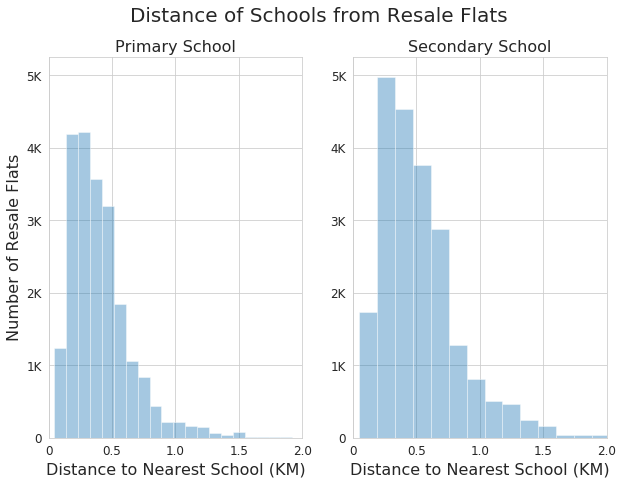

In [75]:
fig, ax = plt.subplots(1,2,figsize=(10,7))



sns.distplot(houses.nearest_sch_primary_dist, bins=25, ax=ax[0], kde=False)
sns.distplot(houses.nearest_sch_secondary_dist, bins=25, ax=ax[1], kde=False)


fig.suptitle('Distance of Schools from Resale Flats', fontsize=20)

ax[0].set_xlabel('Distance to Nearest School (KM)', fontsize=16)
ax[0].set_ylabel('Number of Resale Flats', fontsize=16)
ax[0].set_title('Primary School', fontsize=16)
ax[0].set_xlim(0,2)
ax[0].set_xticks(np.arange(0,2.5,step=0.5))
ax[0].set_xticklabels([0,0.5,1.0,1.5,2.0,2.5], fontsize=12)
ax[0].set_yticks(np.arange(0,6000,step=1000))
ax[0].set_yticklabels(['0', '1K','2K','3K','4K','5K'], fontsize=12)
ax[0].set_ylim(0,5250)

ax[1].set_xlabel('Distance to Nearest School (KM)', fontsize=16)
ax[1].set_ylabel('', fontsize=16)
ax[1].set_title('Secondary School', fontsize=16)
ax[1].set_xlim(0,2)
ax[1].set_xticks(np.arange(0,2.5,step=0.5))
ax[1].set_xticklabels([0,0.5,1.0,1.5,2.0,2.5], fontsize=12)
ax[1].set_yticks(np.arange(0,6000,step=1000))
ax[1].set_yticklabels(['0', '1K','2K','3K','4K','5K'], fontsize=12)
ax[1].set_ylim(0,5250)

In [76]:
temp = houses[['nearest_sch_primary_dist',
        'nearest_sch_secondary_dist']]

temp.columns = ['Primary School',
                'Secondary School']

temp.describe()

,Primary School,Secondary School
count,"21,569.00","21,569.00"
mean,0.41,0.52
std,0.25,0.32
min,0.05,0.05
25%,0.23,0.29
50%,0.35,0.46
75%,0.50,0.66
max,2.39,3.58


In [77]:
### Effect of MRT distance on Prices

In [78]:
houses['nearest_MRTandBus_dist'] = 0.0
houses['nearest_MRTorBus_dist'] = 0.0

for index in houses.index:
    houses.loc[index, 'nearest_MRTorBus_dist'] = min(houses.loc[index,'nearest_mrt_dist'],
                                                     houses.loc[index,'busstop1_dist'])
    houses.loc[index, 'nearest_MRTandBus_dist'] = max(houses.loc[index,'nearest_mrt_dist'],
                                                     houses.loc[index,'busstop1_dist'])

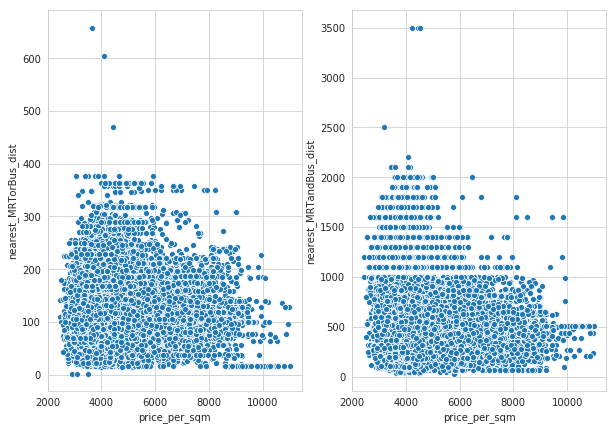

In [79]:
fig, ax = plt.subplots(1,2, figsize=(10,7))
sns.scatterplot(x='price_per_sqm',y='nearest_MRTorBus_dist', 
                data=houses, 
                ax=ax[0])
sns.scatterplot(x='price_per_sqm',y='nearest_MRTandBus_dist', 
                data=houses, ax=ax[1])

Text(0.5, 0, 'Price per SqM')

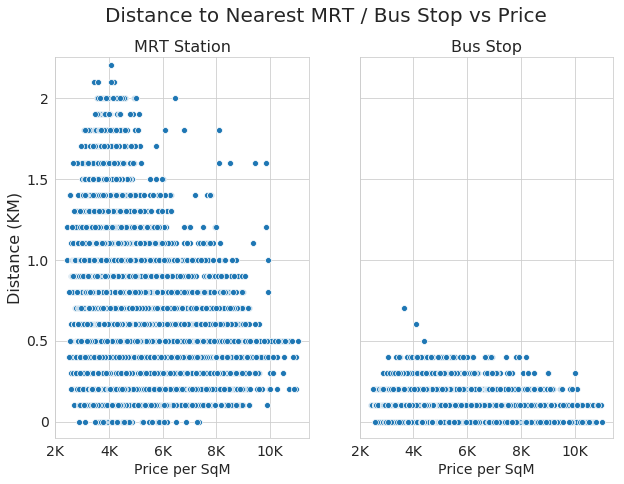

In [80]:
houses['nearest_mrt_dist_100'] = houses.nearest_mrt_dist.map(lambda x:
                                                            round(x,-2))
houses['busstop1_dist_100'] = houses.busstop1_dist.map(lambda x:
                                                            round(x,-2))



fig, ax = plt.subplots(1,2, figsize=(10,7))
# sns.scatterplot(x='price_per_sqm',y='nearest_mrt_dist', 
#                 data=houses, 
#                 ax=ax[0])
# sns.scatterplot(x='price_per_sqm',y='busstop1_dist', 
#                 data=houses, ax=ax[1])

sns.scatterplot(x='price_per_sqm',y='nearest_mrt_dist_100', 
                data=houses, 
                ax=ax[0])
sns.scatterplot(x='price_per_sqm',y='busstop1_dist_100', 
                data=houses, ax=ax[1])

fig.suptitle('Distance to Nearest MRT / Bus Stop vs Price', fontsize=20)

ax[0].set_title('MRT Station', fontsize=16)
ax[0].set_ylim(-100,2250)
ax[0].set_yticklabels([-0.5, 0, 0.5, 1.0, 1.5, 2], fontsize=14)
ax[0].set_ylabel('Distance (KM)', fontsize=16)
ax[0].set_xticklabels(['2K','4K','6K','8K','10K'], fontsize=14)
ax[0].set_xlabel('Price per SqM', fontsize=14)


ax[1].set_title('Bus Stop', fontsize=16)
ax[1].set_ylim(-100,2250)
ax[1].set_yticklabels(['0, 0.5, 1, 1.5, 2'], fontsize=14)
ax[1].set_ylabel('', fontsize=16)
ax[1].set_xticklabels(['2K','4K','6K','8K','10K'], fontsize=14)
ax[1].set_xlabel('Price per SqM', fontsize=14)

(0, 5000)

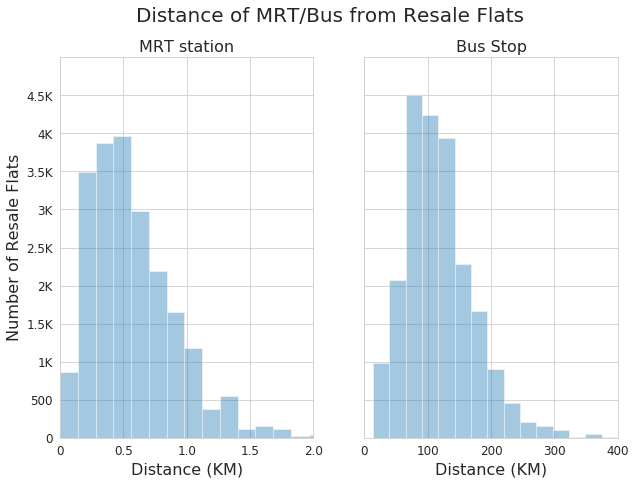

In [81]:
fig, ax = plt.subplots(1,2,figsize=(10,7))

sns.distplot(houses.nearest_mrt_dist, ax=ax[0], kde=False, bins = 25)
sns.distplot(houses.busstop1_dist, ax=ax[1], kde=False, bins=25)

fig.suptitle('Distance of MRT/Bus from Resale Flats', fontsize=20)

ax[0].set_title('MRT station', fontsize=16)
ax[0].set_xlabel('Distance (KM)', fontsize=16)
ax[0].set_ylabel('Number of Resale Flats', fontsize=16)
ax[0].set_xlim(0,2000)
ax[0].set_xticks(np.arange(0,2500,step=500))
ax[0].set_xticklabels([0,0.5,1.0,1.5,2.0,2.5], fontsize=12)
ax[0].set_yticks(np.arange(0,5000,step=500))
ax[0].set_yticklabels([0, 500, '1K', '1.5K', '2K', '2.5K', '3K',
                       '3.5K', '4K', '4.5K'], fontsize=12)
ax[0].set_ylim(0,5000)

ax[1].set_title('Bus Stop', fontsize=16)
ax[1].set_xlabel('Distance (KM)', fontsize=16)
ax[1].set_ylabel('', fontsize=16)
ax[1].set_xlim(0,400)
ax[1].set_xticks(np.arange(0,500,step=100))
ax[1].set_xticklabels([0,100,200,300,400,500], fontsize=12)
ax[1].set_yticks(np.arange(0,5000,step=500))
ax[1].set_yticklabels('')
# ax[1].set_yticklabels([0, 500, '1K', '1.5K', '2K', '2.5K', '3K',
#                        '3.5K', '4K', '4.5K'], fontsize=12)
ax[1].set_ylim(0,5000)

In [82]:
temp = houses[['nearest_mrt_dist','busstop1_dist']]
temp.columns = ['MRT', 'Bus']
temp.describe()

,MRT,Bus
count,"21,569.00","21,569.00"
mean,574.70,118.24
std,339.38,54.46
min,2.00,14.00
25%,314.00,82.00
50%,507.00,111.00
75%,766.00,146.00
max,"3,500.00",658.00


In [83]:
houses[['nearest_mrt_dist','price_per_sqm']].corr()

,nearest_mrt_dist,price_per_sqm
nearest_mrt_dist,1.00,-0.17
price_per_sqm,-0.17,1.00


In [84]:
houses[['busstop1_dist','price_per_sqm']].corr()

,busstop1_dist,price_per_sqm
busstop1_dist,1.00,0.04
price_per_sqm,0.04,1.00


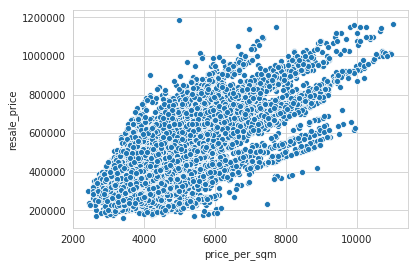

In [85]:
sns.scatterplot(x='price_per_sqm',y='resale_price', data=houses)

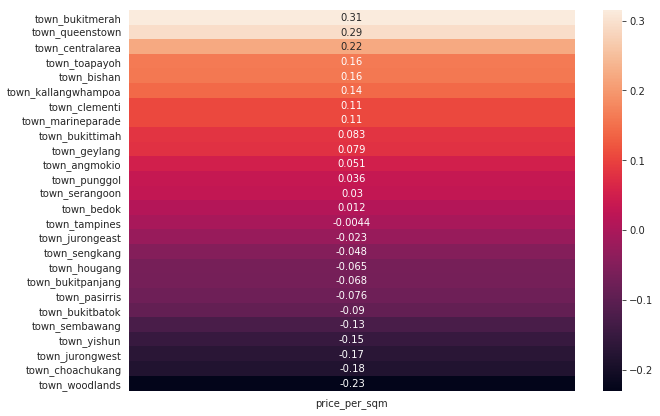

In [86]:
### towns

cols = [col for col in houses.columns if 'town_' in col] + ['price_per_sqm']


fig, ax = plt.subplots(1,1,figsize=(10,7))
corr = houses[cols].corr()['price_per_sqm'][:-1]
corr.sort_values(ascending=False, inplace=True)

sns.heatmap(corr.to_frame(), annot=True)

In [87]:
houses.columns.values

array(['month', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'remaining_lease', 'resale_price',
       'transaction_year', 'transaction_month', 'loc_lat', 'loc_lon',
       'nearest_mrt_name', 'nearest_mrt_dist', 'nearest_mrt_code',
       'nearest_mrt_line', 'nearest_mrt_lat', 'nearest_mrt_lon',
       'nearest_mrt_dist_centre', 'busstop1_name', 'busstop1_code',
       'busstop1_dist', 'busstop2_name', 'busstop2_code', 'busstop2_dist',
       'busstop3_name', 'busstop3_code', 'busstop3_dist',
       'nearest_sch_primary_name', 'nearest_sch_primary_address',
       'nearest_sch_primary_postalcode', 'nearest_sch_primary_lat',
       'nearest_sch_primary_lon', 'nearest_sch_primary_dist',
       'nearest_sch_primary_sap', 'nearest_sch_secondary_name',
       'nearest_sch_secondary_address',
       'nearest_sch_secondary_postalcode', 'nearest_sch_secondary_lat',
       'nearest_sch_secondary_lon', 'nearest

# MODELLING

In [88]:
#############################################
# MODELLLING
#############################################

In [89]:
# # approach 1: throw everything inside


# # create predictor and target
# X1 = houses[['floor_area_sqm', 'remaining_lease', 
              
#             'nearest_mrt_dist', 'busstop1_dist', 

#             'nearest_sch_primary_dist', 'nearest_sch_primary_sap', 
#             'nearest_sch_secondary_dist', 'nearest_sch_secondary_sap', 
#             'floor_0103', 'floor_0406', 'floor_0709', 'floor_1012',
#             'floor_1315', 'floor_1618', 'floor_1921', 'floor_2224',
#             'floor_2527', 'floor_2830', 'floor_3133', 'floor_3436',
#             'floor_3739', 'floor_4042', 'floor_4345', 'floor_4648',
#             'floor_4951', 

#             'town_angmokio', 'town_bedok', 'town_bishan',
#             'town_bukitbatok', 'town_bukitmerah', 'town_bukitpanjang',
#             'town_bukittimah', 'town_centralarea', 'town_choachukang',
#             'town_clementi', 'town_geylang', 'town_hougang', 'town_jurongeast',
#             'town_jurongwest', 'town_kallangwhampoa', 'town_marineparade',
#             'town_pasirris', 'town_punggol', 'town_queenstown',
#             'town_sembawang', 'town_sengkang', 'town_serangoon',
#             'town_tampines', 'town_toapayoh', 'town_woodlands', 'town_yishun',

#             'room_2room', 'room_3room', 'room_4room', 'room_5room',
#             'room_executive', 'room_1room', 'room_multigeneration',

#             'flatmodel_improved', 'flatmodel_newgeneration',
#             'flatmodel_modela', 'flatmodel_dbss', 'flatmodel_adjoinedflat',
#             'flatmodel_simplified', 'flatmodel_premiumapartment',
#             'flatmodel_standard', 'flatmodel_maisonette',
#             'flatmodel_apartment', 'flatmodel_modela2', 'flatmodel_types1',
#             'flatmodel_types2', 'flatmodel_premiummaisonette',
#             'flatmodel_terrace', 'flatmodel_modelamaisonette',
#             'flatmodel_improvedmaisonette', 'flatmodel_multigeneration',
#             'flatmodel_premiumapartmentloft'        
#             ]]
# y1 = houses['resale_price']
# # train test split
# X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
# # define the category and qty(continuous) columns
# # X1_qty_cols = ['floor_area_sqm', 'remaining_lease', 
# #                'nearest_mrt_dist', 'busstop1_dist', 
# #                'nearest_sch_primary_dist', 'nearest_sch_secondary_dist']
# # X1_cat_cols = [col for col in X1.columns if col not in X1_qty_cols]
# # # standard scale the qty columns in the training set, then combine back into the training predictor
# # X1_train_qty = X1_train[X1_qty_cols]
# # X1_ss = StandardScaler().fit(X1_train_qty.astype(float))
# # X1_train_qty = pd.DataFrame(X1_ss.transform(X1_train_qty.astype(float)))
# # X1_train_qty.columns = X1_qty_cols
# # X1_train_cat = X1_train[X1_cat_cols]
# # X1_train = pd.concat([X1_train_qty.reset_index(drop=True), 
# #                       X1_train_cat.reset_index(drop=True)], axis=1)
# # # standard scale (transform) qty columns in test set, combine back into test predictor
# # X1_test_qty = X1_test[X1_qty_cols]
# # X1_test_qty = pd.DataFrame(X1_ss.transform(X1_test_qty.astype(float)))
# # X1_test_qty.columns = X1_qty_cols
# # X1_test_cat = X1_test[X1_cat_cols]
# # X1_test = pd.concat([X1_test_qty.reset_index(drop=True), 
# #                      X1_test_cat.reset_index(drop=True)], axis=1)

In [90]:
# approach 1: throw everything inside


# create predictor and target
X1 = houses[['floor_area_sqm', 'remaining_lease', 
              
            'nearest_mrt_dist', 'busstop1_dist', 'nearest_mrt_dist_centre',

            'nearest_sch_primary_dist', 'nearest_sch_secondary_dist',  
            'floor_0103', 'floor_0406', 'floor_0709', 'floor_1012',
            'floor_1315', 'floor_1618', 'floor_1921', 'floor_2224',
            'floor_2527', 'floor_2830', 'floor_3133', 'floor_3436',
            'floor_3739', 'floor_4042', 'floor_4345', 'floor_4648',
            'floor_4951', 

            'town_angmokio', 'town_bedok', 'town_bishan',
            'town_bukitbatok', 'town_bukitmerah', 'town_bukitpanjang',
            'town_bukittimah', 'town_centralarea', 'town_choachukang',
            'town_clementi', 'town_geylang', 'town_hougang', 'town_jurongeast',
            'town_jurongwest', 'town_kallangwhampoa', 'town_marineparade',
            'town_pasirris', 'town_punggol', 'town_queenstown',
            'town_sembawang', 'town_sengkang', 'town_serangoon',
            'town_tampines', 'town_toapayoh', 'town_woodlands', 'town_yishun',

            'room_2room', 'room_3room', 'room_4room', 'room_5room',
            'room_executive', 'room_1room', 'room_multigeneration',

            'flatmodel_improved', 'flatmodel_newgeneration',
            'flatmodel_modela', 'flatmodel_dbss', 'flatmodel_adjoinedflat',
            'flatmodel_simplified', 'flatmodel_premiumapartment',
            'flatmodel_standard', 'flatmodel_maisonette',
            'flatmodel_apartment', 'flatmodel_modela2', 'flatmodel_types1',
            'flatmodel_types2', 'flatmodel_premiummaisonette',
            'flatmodel_terrace', 'flatmodel_modelamaisonette',
            'flatmodel_improvedmaisonette', 'flatmodel_multigeneration',
            'flatmodel_premiumapartmentloft'        
            ]]
y1 = houses['resale_price']


# train test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
# define the category and qty(continuous) columns
# X1_qty_cols = ['floor_area_sqm', 'remaining_lease', 
#                'nearest_mrt_dist', 'busstop1_dist', 
#                'nearest_sch_primary_dist', 'nearest_sch_secondary_dist']
# X1_cat_cols = [col for col in X1.columns if col not in X1_qty_cols]
# # standard scale the qty columns in the training set, then combine back into the training predictor
# X1_train_qty = X1_train[X1_qty_cols]
# X1_ss = StandardScaler().fit(X1_train_qty.astype(float))
# X1_train_qty = pd.DataFrame(X1_ss.transform(X1_train_qty.astype(float)))
# X1_train_qty.columns = X1_qty_cols
# X1_train_cat = X1_train[X1_cat_cols]
# X1_train = pd.concat([X1_train_qty.reset_index(drop=True), 
#                       X1_train_cat.reset_index(drop=True)], axis=1)
# # standard scale (transform) qty columns in test set, combine back into test predictor
# X1_test_qty = X1_test[X1_qty_cols]
# X1_test_qty = pd.DataFrame(X1_ss.transform(X1_test_qty.astype(float)))
# X1_test_qty.columns = X1_qty_cols
# X1_test_cat = X1_test[X1_cat_cols]
# X1_test = pd.concat([X1_test_qty.reset_index(drop=True), 
#                      X1_test_cat.reset_index(drop=True)], axis=1)

In [91]:
# performing regression -> fit, predict, find error
X1_linreg = LinearRegression()
X1_linreg.fit(X1_train, y1_train)
y1_predicted = X1_linreg.predict(X1_test)
y1_error = pd.DataFrame([y1_predicted, y1_test, y1_predicted - y1_test]).transpose()
y1_error.columns = ['predicted', 'actual', 'error']
y1_error['abs_error'] = np.abs(y1_error['error'])
# get score
score = metrics.r2_score(y1_test, y1_predicted)
print('R2 score: {:.4f}'.format(score))

R2 score: 0.8737


In [92]:
desc = y1_error.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.2f}'.format)
desc

,predicted,actual,error,abs_error
count,6471,6471,6471,6471
mean,438921.06,439448.23,-527.18,42643.71
std,146656.81,157360.04,55926.73,36184.38
min,57884.61,160000.00,-276625.17,6.50
25%,339113.22,328000.00,-30757.68,16240.83
50%,425128.21,405000.00,4483.20,34026.86
75%,514188.05,510000.00,36106.04,58470.72
max,1043673.40,1150000.00,224917.82,276625.17


In [93]:
X1_coefs = pd.DataFrame(X1_linreg.coef_).transpose()
X1_coefs.columns = X1_train.columns.values
X1_coefs = X1_coefs.transpose()
X1_coefs.columns = ['coeff']
X1_coefs['abs_coeff'] = X1_coefs['coeff'].map(lambda x: np.abs(x))
X1_coefs['weightage'] = 100*X1_coefs['coeff'] / X1_coefs['coeff'].sum()
X1_coefs['abs_weightage'] = 100*X1_coefs['abs_coeff'] / X1_coefs['abs_coeff'].sum()

# X1_coefs.sort_values(by='abs_weightage', ascending = False, inplace=True)
X1_coefs.sort_values(by='weightage', ascending = False, inplace=True)

In [94]:
R_selector = RFECV(LinearRegression(), step=1, cv=10)
R_selector.fit(X1_train, y1_train)
R_cols = np.array(X1_train.columns)[R_selector.support_]
print('RFECV recommends to use only {} of {} columns, which are: \n{}'.format(
    len(R_cols), len(X1_train.columns), R_cols))

RFECV recommends to use only 73 of 76 columns, which are: 
['floor_area_sqm' 'remaining_lease' 'nearest_mrt_dist'
 'nearest_mrt_dist_centre' 'nearest_sch_primary_dist'
 'nearest_sch_secondary_dist' 'floor_0103' 'floor_0406' 'floor_0709'
 'floor_1012' 'floor_1315' 'floor_1618' 'floor_1921' 'floor_2224'
 'floor_2527' 'floor_2830' 'floor_3133' 'floor_3436' 'floor_3739'
 'floor_4042' 'floor_4648' 'town_angmokio' 'town_bedok' 'town_bishan'
 'town_bukitbatok' 'town_bukitmerah' 'town_bukitpanjang' 'town_bukittimah'
 'town_centralarea' 'town_choachukang' 'town_clementi' 'town_geylang'
 'town_hougang' 'town_jurongeast' 'town_jurongwest' 'town_kallangwhampoa'
 'town_marineparade' 'town_pasirris' 'town_punggol' 'town_queenstown'
 'town_sembawang' 'town_sengkang' 'town_serangoon' 'town_tampines'
 'town_toapayoh' 'town_woodlands' 'town_yishun' 'room_2room' 'room_3room'
 'room_4room' 'room_5room' 'room_executive' 'room_1room'
 'room_multigeneration' 'flatmodel_improved' 'flatmodel_newgeneration'
 'f

In [95]:
# performing regression -> fit, predict, find error
X1_linreg = LinearRegression()
X1_linreg.fit(X1_train[R_cols], y1_train)
y1_predicted = X1_linreg.predict(X1_test[R_cols])
y1_error = pd.DataFrame([y1_predicted, y1_test, y1_predicted - y1_test]).transpose()
y1_error.columns = ['predicted', 'actual', 'error']
y1_error['abs_error'] = np.abs(y1_error['error'])
# get score
score = metrics.r2_score(y1_test, y1_predicted)
print('R2 score: {:.4f}'.format(score))
print('Score is same as before RFECV -> stick to original')

R2 score: 0.8736
Score is same as before RFECV -> stick to original


In [96]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=0)
optimal_lasso.fit(X1_train, y1_train)
print('Optimal Alpha value is : ', optimal_lasso.alpha_)

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(X1_train, y1_train)

lasso_coefs = pd.DataFrame({'variable':X1_train.columns,
                           'coef':lasso.coef_,
                           'abs_coef': np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print('Number of columns remaining:', len(lasso_coefs[lasso_coefs['coef'] != 0]), 'of', len(lasso_coefs))
print('Percent variables zeroed out:', round(len(lasso_coefs[lasso_coefs['coef'] == 0])*100/float(len(lasso_coefs)),2), '%')
print('-'*20)
coefs = lasso_coefs[lasso_coefs['coef'] != 0]['variable']
L_cols = [col for col in coefs]

print('Columns to keep are: \n{}'.format(L_cols))

X1_linreg_lasso = LinearRegression().fit(X1_train[L_cols], y1_train)
X1_linreg_score = X1_linreg_lasso.score(X1_test[L_cols], y1_test)
print('-'*20)
print('Prediction score after lasso: {:4f}'.format(X1_linreg_score))
print('Score is worst than original -> stick to original')

Optimal Alpha value is :  4687.802870201902
Number of columns remaining: 7 of 76
Percent variables zeroed out: 90.79 %
--------------------
Columns to keep are: 
['nearest_mrt_dist_centre', 'town_sengkang', 'floor_0103', 'floor_area_sqm', 'remaining_lease', 'busstop1_dist', 'nearest_mrt_dist']
--------------------
Prediction score after lasso: 0.690509
Score is worst than original -> stick to original


In [97]:
# approach 2: take only following columns:
# floor area, lease, floor, town, room type

In [98]:
# create predictor and target
X2 = houses[['floor_area_sqm', 
             
             'remaining_lease', 
              
            'floor_0103', 'floor_0406', 'floor_0709', 'floor_1012',
            'floor_1315', 'floor_1618', 'floor_1921', 'floor_2224',
            'floor_2527', 'floor_2830', 'floor_3133', 'floor_3436',
            'floor_3739', 'floor_4042', 'floor_4345', 'floor_4648',
            'floor_4951', 

            'town_angmokio', 'town_bedok', 'town_bishan',
            'town_bukitbatok', 'town_bukitmerah', 'town_bukitpanjang',
            'town_bukittimah', 'town_centralarea', 'town_choachukang',
            'town_clementi', 'town_geylang', 'town_hougang', 'town_jurongeast',
            'town_jurongwest', 'town_kallangwhampoa', 'town_marineparade',
            'town_pasirris', 'town_punggol', 'town_queenstown',
            'town_sembawang', 'town_sengkang', 'town_serangoon',
            'town_tampines', 'town_toapayoh', 'town_woodlands', 'town_yishun',

            'room_2room', 'room_3room', 'room_4room', 'room_5room',
            'room_executive', 'room_1room', 'room_multigeneration',

            ]]
y2 = houses['resale_price']
# train test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)
# # define the category and qty(continuous) columns
# X2_qty_cols = ['floor_area_sqm', 'remaining_lease']
# X2_cat_cols = [col for col in X2.columns if col not in X2_qty_cols]
# # standard scale the qty columns in the training set, then combine back into the training predictor
# X2_train_qty = X2_train[X2_qty_cols]
# X2_ss = StandardScaler().fit(X2_train_qty.astype(float))
# X2_train_qty = pd.DataFrame(X2_ss.transform(X2_train_qty.astype(float)))
# X2_train_qty.columns = X2_qty_cols
# X2_train_cat = X2_train[X2_cat_cols]
# X2_train = pd.concat([X2_train_qty.reset_index(drop=True), 
#                       X2_train_cat.reset_index(drop=True)], axis=1)
# # standard scale (transform) qty columns in test set, combine back into test predictor
# X2_test_qty = X2_test[X2_qty_cols]
# X2_test_qty = pd.DataFrame(X2_ss.transform(X2_test_qty.astype(float)))
# X2_test_qty.columns = X2_qty_cols
# X2_test_cat = X2_test[X2_cat_cols]
# X2_test = pd.concat([X2_test_qty.reset_index(drop=True), 
#                      X2_test_cat.reset_index(drop=True)], axis=1)

In [99]:
# performing regression -> fit, predict, find error
X2_linreg = LinearRegression()
X2_linreg.fit(X2_train, y2_train)
y2_predicted = X2_linreg.predict(X2_test)
y2_error = pd.DataFrame([y2_predicted, y2_test, y2_predicted - y2_test]).transpose()
y2_error.columns = ['predicted', 'actual', 'error']
y2_error['abs_error'] = np.abs(y2_error['error'])
# get score
score = metrics.r2_score(y2_test, y2_predicted)
print('R2 score: {:.4f}'.format(score))

R2 score: 0.8505


In [100]:
desc = y2_error.describe()
desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
desc.iloc[1:] = desc.iloc[1:].applymap('{:.2f}'.format)
desc

,predicted,actual,error,abs_error
count,6471,6471,6471,6471
mean,439165.30,439448.23,-282.93,46783.76
std,144978.79,157360.04,60850.30,38907.34
min,39784.11,160000.00,-309179.43,8.19
25%,338076.07,328000.00,-34478.83,17960.61
50%,427315.96,405000.00,5080.81,37411.26
75%,522663.14,510000.00,39998.78,65531.27
max,959993.67,1150000.00,243681.98,309179.43


In [101]:
X2_coefs = pd.DataFrame(X2_linreg.coef_).transpose()
X2_coefs.columns = X2_train.columns.values
X2_coefs = X2_coefs.transpose()
X2_coefs.sort_values(by=0, ascending = False).head(10)

,0
town_bukittimah,"223,636.06"
town_centralarea,"191,562.01"
town_marineparade,"191,399.83"
floor_4648,"144,863.32"
room_multigeneration,"131,978.14"
town_queenstown,"129,949.61"
town_bishan,"129,399.33"
floor_4042,"127,967.78"
town_bukitmerah,"118,565.89"
floor_3739,"101,446.34"


In [102]:
R_selector = RFECV(LinearRegression(), step=1, cv=10)
R_selector.fit(X2_train, y2_train)
R_cols = np.array(X2_train.columns)[R_selector.support_]
print('RFECV recommends to use only {} of {} columns, which are: \n{}'.format(
    len(R_cols), len(X2_train.columns), R_cols))
# RFECV not helping!

RFECV recommends to use only 50 of 52 columns, which are: 
['floor_area_sqm' 'remaining_lease' 'floor_0103' 'floor_0406' 'floor_0709'
 'floor_1012' 'floor_1315' 'floor_1618' 'floor_1921' 'floor_2224'
 'floor_2527' 'floor_2830' 'floor_3133' 'floor_3436' 'floor_3739'
 'floor_4042' 'floor_4648' 'town_angmokio' 'town_bedok' 'town_bishan'
 'town_bukitbatok' 'town_bukitmerah' 'town_bukitpanjang' 'town_bukittimah'
 'town_centralarea' 'town_choachukang' 'town_clementi' 'town_geylang'
 'town_hougang' 'town_jurongeast' 'town_jurongwest' 'town_kallangwhampoa'
 'town_marineparade' 'town_pasirris' 'town_punggol' 'town_queenstown'
 'town_sembawang' 'town_sengkang' 'town_serangoon' 'town_tampines'
 'town_toapayoh' 'town_woodlands' 'town_yishun' 'room_2room' 'room_3room'
 'room_4room' 'room_5room' 'room_executive' 'room_1room'
 'room_multigeneration']


In [103]:
# performing regression -> fit, predict, find error
X2_linreg = LinearRegression()
X2_linreg.fit(X2_train[R_cols], y2_train)
y2_predicted = X2_linreg.predict(X2_test[R_cols])
y2_error = pd.DataFrame([y2_predicted, y2_test, y2_predicted - y2_test]).transpose()
y2_error.columns = ['predicted', 'actual', 'error']
y2_error['abs_error'] = np.abs(y2_error['error'])
# get score
score = metrics.r2_score(y2_test, y2_predicted)
print('R2 score: {:.4f}'.format(score))
# no improvement from before RFECV

R2 score: 0.8505


In [104]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=0)
optimal_lasso.fit(X2_train, y2_train)
print('Optimal Alpha value is : ', optimal_lasso.alpha_)

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso.fit(X2_train, y2_train)

lasso_coefs = pd.DataFrame({'variable':X2_train.columns,
                           'coef':lasso.coef_,
                           'abs_coef': np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print('Number of columns remaining:', len(lasso_coefs[lasso_coefs['coef'] != 0]), 'of', len(lasso_coefs))
print('Percent variables zeroed out:', round(len(lasso_coefs[lasso_coefs['coef'] == 0])*100/float(len(lasso_coefs)),2), '%')
print('-'*20)
coefs = lasso_coefs[lasso_coefs['coef'] != 0]['variable']
L_cols = [col for col in coefs]

print('Columns to keep are: \n{}'.format(L_cols))

X2_linreg_lasso = LinearRegression().fit(X2_train[L_cols], y2_train)
X2_linreg_score = X2_linreg_lasso.score(X2_test[L_cols], y2_test)
print('-'*20)
print('Prediction score after lasso: {:4f}'.format(X2_linreg_score))
print('Score is worst than original -> stick to original')

Optimal Alpha value is :  2452.111042286245
Number of columns remaining: 17 of 52
Percent variables zeroed out: 67.31 %
--------------------
Columns to keep are: 
['town_bukitmerah', 'town_queenstown', 'town_woodlands', 'town_choachukang', 'town_jurongwest', 'town_toapayoh', 'town_sengkang', 'town_sembawang', 'floor_0103', 'town_bishan', 'town_yishun', 'town_kallangwhampoa', 'floor_0406', 'town_punggol', 'floor_0709', 'floor_area_sqm', 'remaining_lease']
--------------------
Prediction score after lasso: 0.748992
Score is worst than original -> stick to original


In [105]:
###################################################
# final results: approach 1
###################################################

In [106]:
# approach 1: throw everything inside


# create predictor and target
X1 = houses[['floor_area_sqm', 'remaining_lease', 
              
            'nearest_mrt_dist', 'busstop1_dist', 'nearest_mrt_dist_centre',

            'nearest_sch_primary_dist', 'nearest_sch_secondary_dist',  
            'floor_0103', 'floor_0406', 'floor_0709', 'floor_1012',
            'floor_1315', 'floor_1618', 'floor_1921', 'floor_2224',
            'floor_2527', 'floor_2830', 'floor_3133', 'floor_3436',
            'floor_3739', 'floor_4042', 'floor_4345', 'floor_4648',
            'floor_4951', 

            'town_angmokio', 'town_bedok', 'town_bishan',
            'town_bukitbatok', 'town_bukitmerah', 'town_bukitpanjang',
            'town_bukittimah', 'town_centralarea', 'town_choachukang',
            'town_clementi', 'town_geylang', 'town_hougang', 'town_jurongeast',
            'town_jurongwest', 'town_kallangwhampoa', 'town_marineparade',
            'town_pasirris', 'town_punggol', 'town_queenstown',
            'town_sembawang', 'town_sengkang', 'town_serangoon',
            'town_tampines', 'town_toapayoh', 'town_woodlands', 'town_yishun',

            'room_2room', 'room_3room', 'room_4room', 'room_5room',
            'room_executive', 'room_1room', 'room_multigeneration',

            'flatmodel_improved', 'flatmodel_newgeneration',
            'flatmodel_modela', 'flatmodel_dbss', 'flatmodel_adjoinedflat',
            'flatmodel_simplified', 'flatmodel_premiumapartment',
            'flatmodel_standard', 'flatmodel_maisonette',
            'flatmodel_apartment', 'flatmodel_modela2', 'flatmodel_types1',
            'flatmodel_types2', 'flatmodel_premiummaisonette',
            'flatmodel_terrace', 'flatmodel_modelamaisonette',
            'flatmodel_improvedmaisonette', 'flatmodel_multigeneration',
            'flatmodel_premiumapartmentloft'        
            ]]
y1 = houses['resale_price']


In [107]:
# # train test split
# X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [108]:
# training / split

pred_cols = ['floor_area_sqm', 'remaining_lease', 
              
            'nearest_mrt_dist', 'busstop1_dist', 'nearest_mrt_dist_centre',

            'nearest_sch_primary_dist', 'nearest_sch_secondary_dist',  
            'floor_0103', 'floor_0406', 'floor_0709', 'floor_1012',
            'floor_1315', 'floor_1618', 'floor_1921', 'floor_2224',
            'floor_2527', 'floor_2830', 'floor_3133', 'floor_3436',
            'floor_3739', 'floor_4042', 'floor_4345', 'floor_4648',
            'floor_4951', 

            'town_angmokio', 'town_bedok', 'town_bishan',
            'town_bukitbatok', 'town_bukitmerah', 'town_bukitpanjang',
            'town_bukittimah', 'town_centralarea', 'town_choachukang',
            'town_clementi', 'town_geylang', 'town_hougang', 'town_jurongeast',
            'town_jurongwest', 'town_kallangwhampoa', 'town_marineparade',
            'town_pasirris', 'town_punggol', 'town_queenstown',
            'town_sembawang', 'town_sengkang', 'town_serangoon',
            'town_tampines', 'town_toapayoh', 'town_woodlands', 'town_yishun',

            'room_2room', 'room_3room', 'room_4room', 'room_5room',
            'room_executive', 'room_1room', 'room_multigeneration',

            'flatmodel_improved', 'flatmodel_newgeneration',
            'flatmodel_modela', 'flatmodel_dbss', 'flatmodel_adjoinedflat',
            'flatmodel_simplified', 'flatmodel_premiumapartment',
            'flatmodel_standard', 'flatmodel_maisonette',
            'flatmodel_apartment', 'flatmodel_modela2', 'flatmodel_types1',
            'flatmodel_types2', 'flatmodel_premiummaisonette',
            'flatmodel_terrace', 'flatmodel_modelamaisonette',
            'flatmodel_improvedmaisonette', 'flatmodel_multigeneration',
            'flatmodel_premiumapartmentloft'        
            ]

test_index = houses[houses.transaction_month==12].index
train_index = [ind for ind in houses.index if ind not in test_index]

X1_train = houses.loc[train_index,:]
X1_train = X1_train[pred_cols]
y1_train = houses.loc[train_index, 'price_per_sqm']

X1_test = houses.loc[test_index,:]
X1_test = X1_test[pred_cols]
y1_test = houses.loc[test_index, 'price_per_sqm']

In [109]:
len(X1_train)

20143

In [110]:
len(X1_test)

1426

In [111]:
# performing regression -> fit, predict, find error
X1_linreg = LinearRegression()
X1_linreg.fit(X1_train, y1_train)
y1_predicted = X1_linreg.predict(X1_test)
y1_error = pd.DataFrame([y1_predicted, y1_test, y1_predicted - y1_test]).transpose()
y1_error.columns = ['predicted', 'actual', 'error']
y1_error['abs_error'] = np.abs(y1_error['error'])
# get score
score = metrics.r2_score(y1_test, y1_predicted)
print('R2 score: {:.4f}'.format(score))

R2 score: 0.8205


In [112]:
X1_coefs = pd.DataFrame(X1_linreg.coef_).transpose()
X1_coefs.columns = X1_train.columns.values
X1_coefs = X1_coefs.transpose()
X1_coefs.columns = ['coeff']
X1_coefs['abs_coeff'] = X1_coefs['coeff'].map(lambda x: np.abs(x))
X1_coefs['weightage'] = 100*X1_coefs['coeff'] / X1_coefs['coeff'].sum()
X1_coefs['abs_weightage'] = 100*X1_coefs['abs_coeff'] / X1_coefs['abs_coeff'].sum()

# X1_coefs.sort_values(by='abs_weightage', ascending = False, inplace=True)
X1_coefs.sort_values(by='weightage', ascending = False, inplace=True)

In [113]:
X1_coefs[0:20]

,coeff,abs_coeff,weightage,abs_weightage
flatmodel_terrace,"3,208.15","3,208.15",23.42,6.30
town_marineparade,"1,959.39","1,959.39",14.30,3.85
town_bukittimah,"1,905.97","1,905.97",13.91,3.75
flatmodel_improvedmaisonette,"1,688.38","1,688.38",12.32,3.32
town_centralarea,"1,536.47","1,536.47",11.21,3.02
flatmodel_types1,"1,466.27","1,466.27",10.70,2.88
town_queenstown,"1,431.89","1,431.89",10.45,2.81
flatmodel_types2,"1,358.89","1,358.89",9.92,2.67
town_bukitmerah,"1,318.13","1,318.13",9.62,2.59
flatmodel_modelamaisonette,"1,110.47","1,110.47",8.11,2.18


In [114]:
X1_coefs[20:40]

,coeff,abs_coeff,weightage,abs_weightage
floor_3436,649.43,649.43,4.74,1.28
town_toapayoh,620.75,620.75,4.53,1.22
town_geylang,605.47,605.47,4.42,1.19
room_multigeneration,575.44,575.44,4.20,1.13
flatmodel_multigeneration,575.44,575.44,4.20,1.13
floor_4648,570.13,570.13,4.16,1.12
flatmodel_maisonette,496.47,496.47,3.62,0.98
flatmodel_adjoinedflat,424.56,424.56,3.10,0.83
floor_3133,397.15,397.15,2.90,0.78
floor_2830,318.91,318.91,2.33,0.63


In [115]:
X1_coefs[40:]

,coeff,abs_coeff,weightage,abs_weightage
nearest_sch_primary_dist,59.39,59.39,0.43,0.12
room_executive,57.81,57.81,0.42,0.11
remaining_lease,50.70,50.70,0.37,0.10
nearest_sch_secondary_dist,18.21,18.21,0.13,0.04
busstop1_dist,0.08,0.08,0.00,0.00
nearest_mrt_dist,-0.45,0.45,-0.00,0.00
floor_area_sqm,-6.86,6.86,-0.05,0.01
nearest_mrt_dist_centre,-11.76,11.76,-0.09,0.02
flatmodel_modela,-26.35,26.35,-0.19,0.05
flatmodel_improved,-35.32,35.32,-0.26,0.07


In [116]:
X1_coefs.loc['remaining_lease',:]

coeff                          50.70
abs_coeff                      50.70
weightage                       0.37
abs_weightage                   0.10
Name: remaining_lease, dtype: float64

In [117]:
houses.zone.unique()

array(['NORTH', 'EAST', 'CENTRAL', 'WEST', 'NORTH-EAST'], dtype=object)

In [118]:
X1_coefs[X1_coefs.index.str.contains('town_')]

,coeff,abs_coeff,weightage,abs_weightage
town_marineparade,"1,959.39","1,959.39",14.30,3.85
town_bukittimah,"1,905.97","1,905.97",13.91,3.75
town_centralarea,"1,536.47","1,536.47",11.21,3.02
town_queenstown,"1,431.89","1,431.89",10.45,2.81
town_bukitmerah,"1,318.13","1,318.13",9.62,2.59
town_bishan,"1,089.09","1,089.09",7.95,2.14
town_kallangwhampoa,693.26,693.26,5.06,1.36
town_clementi,682.05,682.05,4.98,1.34
town_toapayoh,620.75,620.75,4.53,1.22
town_geylang,605.47,605.47,4.42,1.19


In [119]:
X1_coefs[X1_coefs.index.str.contains('flatmodel_')]

,coeff,abs_coeff,weightage,abs_weightage
flatmodel_terrace,"3,208.15","3,208.15",23.42,6.30
flatmodel_improvedmaisonette,"1,688.38","1,688.38",12.32,3.32
flatmodel_types1,"1,466.27","1,466.27",10.70,2.88
flatmodel_types2,"1,358.89","1,358.89",9.92,2.67
flatmodel_modelamaisonette,"1,110.47","1,110.47",8.11,2.18
flatmodel_dbss,"1,086.91","1,086.91",7.93,2.14
flatmodel_premiummaisonette,908.36,908.36,6.63,1.78
flatmodel_premiumapartmentloft,820.43,820.43,5.99,1.61
flatmodel_multigeneration,575.44,575.44,4.20,1.13
flatmodel_maisonette,496.47,496.47,3.62,0.98


In [120]:
floor_cols = [col for col in X1_coefs.index if (('floor_' in col) &
                                               (len(col)==10))]

X1_coefs[X1_coefs.index.isin(floor_cols)]

,coeff,abs_coeff,weightage,abs_weightage
floor_4951,842.93,842.93,6.15,1.66
floor_4345,775.81,775.81,5.66,1.52
floor_4042,708.24,708.24,5.17,1.39
floor_3739,651.37,651.37,4.75,1.28
floor_3436,649.43,649.43,4.74,1.28
floor_4648,570.13,570.13,4.16,1.12
floor_3133,397.15,397.15,2.90,0.78
floor_2830,318.91,318.91,2.33,0.63
floor_2527,113.48,113.48,0.83,0.22
floor_2224,-159.33,159.33,-1.16,0.31


In [121]:
X1_coefs[X1_coefs.index.str.contains('floor_area')]

,coeff,abs_coeff,weightage,abs_weightage
floor_area_sqm,-6.86,6.86,-0.05,0.01


In [122]:
X1_coefs[X1_coefs.index.str.contains('room_')]

,coeff,abs_coeff,weightage,abs_weightage
room_multigeneration,575.44,575.44,4.20,1.13
room_1room,286.84,286.84,2.09,0.56
room_executive,57.81,57.81,0.42,0.11
room_5room,-129.44,129.44,-0.94,0.25
room_4room,-212.22,212.22,-1.55,0.42
room_2room,-259.88,259.88,-1.90,0.51
room_3room,-318.54,318.54,-2.33,0.63


In [123]:
X1_coefs[X1_coefs.index.str.contains('nearest_mrt') | 
         X1_coefs.index.str.contains('busstop1_')]

,coeff,abs_coeff,weightage,abs_weightage
busstop1_dist,0.08,0.08,0.00,0.00
nearest_mrt_dist,-0.45,0.45,-0.00,0.00
nearest_mrt_dist_centre,-11.76,11.76,-0.09,0.02


In [124]:
X1_coefs[X1_coefs.index.str.contains('nearest_sch')]

,coeff,abs_coeff,weightage,abs_weightage
nearest_sch_primary_dist,59.39,59.39,0.43,0.12
nearest_sch_secondary_dist,18.21,18.21,0.13,0.04


In [125]:
y1_error.describe()

,predicted,actual,error,abs_error
count,"1,426.00","1,426.00","1,426.00","1,426.00"
mean,"4,434.52","4,442.42",-7.90,392.52
std,"1,060.86","1,199.73",508.29,322.86
min,"2,056.35","2,500.00","-2,137.60",0.56
25%,"3,711.42","3,668.37",-300.00,147.22
50%,"4,282.37","4,176.27",26.38,307.37
75%,"4,811.05","4,830.68",318.85,549.17
max,"9,038.53","10,869.57","1,828.03","2,137.60"


In [126]:
y1_test = y1_test.map(lambda x: round(x,2))

In [127]:
y1_test[y1_test == 3181.82]

20545               3,181.82
21459               3,181.82
Name: price_per_sqm, dtype: float64

In [128]:
houses.loc[21459,:]

month                                              2018-12
town                                             WOODLANDS
flat_type                                           5 ROOM
block                                                  325
street_name                                WOODLANDS ST 32
storey_range                                      04 TO 06
floor_area_sqm                                         132
flat_model                                         Model A
lease_commence_date                                   1995
remaining_lease                                         75
resale_price                                        420000
transaction_year                                      2018
transaction_month                                       12
loc_lat                                               1.43
loc_lon                                             103.78
nearest_mrt_name                  MARSILINGMRTSTATION[NS8]
nearest_mrt_dist                                    646.

In [129]:
y1_error.sample(10)

,predicted,actual,error,abs_error
560,"4,017.84","4,316.67",-298.83,298.83
666,"3,626.93","3,479.73",147.20,147.20
17,"4,211.32","4,121.62",89.70,89.70
449,"6,618.34","7,511.11",-892.77,892.77
791,"4,582.71","5,309.28",-726.57,726.57
1324,"3,992.60","3,969.47",23.13,23.13
531,"3,746.62","4,446.28",-699.66,699.66
620,"4,175.61","4,494.12",-318.51,318.51
180,"3,541.36","3,880.60",-339.24,339.24
544,"3,795.21","4,047.62",-252.41,252.41


In [131]:
y1_error.describe()

,predicted,actual,error,abs_error
count,"1,426.00","1,426.00","1,426.00","1,426.00"
mean,"4,434.52","4,442.42",-7.90,392.52
std,"1,060.86","1,199.73",508.29,322.86
min,"2,056.35","2,500.00","-2,137.60",0.56
25%,"3,711.42","3,668.37",-300.00,147.22
50%,"4,282.37","4,176.27",26.38,307.37
75%,"4,811.05","4,830.68",318.85,549.17
max,"9,038.53","10,869.57","1,828.03","2,137.60"


In [132]:
houses.floor_area_sqm.describe()

count              21,569.00
mean                   98.44
std                    24.43
min                    31.00
25%                    82.00
50%                    97.00
75%                   114.00
max                   237.00
Name: floor_area_sqm, dtype: float64

[Text(0, 0, '0'),
 Text(0, 0, '20'),
 Text(0, 0, '40'),
 Text(0, 0, '60'),
 Text(0, 0, '80'),
 Text(0, 0, '100'),
 Text(0, 0, '120'),
 Text(0, 0, '140')]

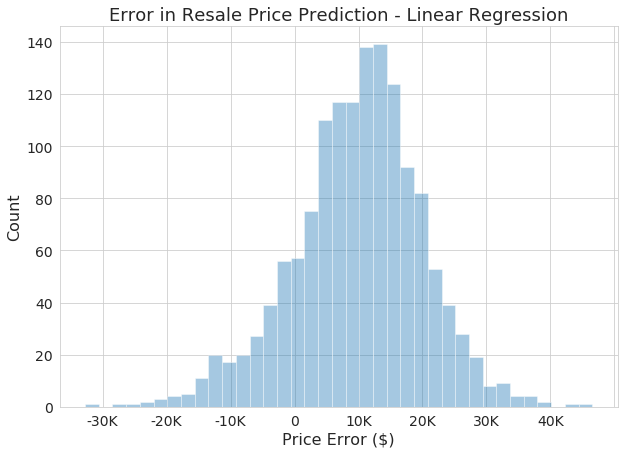

In [146]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

sns.distplot(y1_error.error * 20, kde=False)

ax.set_title('Error in Resale Price Prediction - Linear Regression',
             fontsize=18)
ax.set_xlabel('Price Error ($)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_xticklabels(['-40K','-30K','-20K','-10K',
                    '0','10K','20K','30K','40K'], fontsize=14)
ax.set_yticklabels([0,20,40,60,80,100,120,140], fontsize=14)

In [130]:
houses[['month', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'remaining_lease', 'resale_price',
       'transaction_year', 'transaction_month', 'loc_lat', 'loc_lon',
       'nearest_mrt_name', 'nearest_mrt_dist', 'nearest_mrt_code',
       'nearest_mrt_line', 'nearest_mrt_lat', 'nearest_mrt_lon',
       'nearest_mrt_dist_centre', 'busstop1_name', 'busstop1_code',
       'busstop1_dist', 'busstop2_name', 'busstop2_code', 'busstop2_dist',
       'busstop3_name', 'busstop3_code', 'busstop3_dist',
       'nearest_sch_primary_name', 'nearest_sch_primary_address',
       'nearest_sch_primary_postalcode', 'nearest_sch_primary_lat',
       'nearest_sch_primary_lon', 'nearest_sch_primary_dist',
       'nearest_sch_primary_sap', 'nearest_sch_secondary_name',
       'nearest_sch_secondary_address',
       'nearest_sch_secondary_postalcode', 'nearest_sch_secondary_lat',
       'nearest_sch_secondary_lon', 'nearest_sch_secondary_dist',
       'nearest_sch_secondary_sap', 'nearest_sch_juniorcollege_name',
       'nearest_sch_juniorcollege_address',
       'nearest_sch_juniorcollege_postalcode',
       'nearest_sch_juniorcollege_lat', 'nearest_sch_juniorcollege_lon',
       'nearest_sch_juniorcollege_dist', 'nearest_sch_polytechnic_name',
       'nearest_sch_polytechnic_address',
       'nearest_sch_polytechnic_postalcode',
       'nearest_sch_polytechnic_lat', 'nearest_sch_polytechnic_lon',
       'nearest_sch_polytechnic_dist', 'nearest_sch_university_name',
       'nearest_sch_university_address',
       'nearest_sch_university_postalcode', 'nearest_sch_university_lat',
       'nearest_sch_university_lon', 'nearest_sch_university_dist',
       'floor_0103', 'floor_0406', 'floor_0709', 'floor_1012',
       'floor_1315', 'floor_1618', 'floor_1921', 'floor_2224',
       'floor_2527', 'floor_2830', 'floor_3133', 'floor_3436',
       'floor_3739', 'floor_4042', 'floor_4345', 'floor_4648',
       'floor_4951', 'zone', 'town_angmokio', 'town_bedok', 'town_bishan',
       'town_bukitbatok', 'town_bukitmerah', 'town_bukitpanjang',
       'town_bukittimah', 'town_centralarea', 'town_choachukang',
       'town_clementi', 'town_geylang', 'town_hougang', 'town_jurongeast',
       'town_jurongwest', 'town_kallangwhampoa', 'town_marineparade',
       'town_pasirris', 'town_punggol', 'town_queenstown',
       'town_sembawang', 'town_sengkang', 'town_serangoon',
       'town_tampines', 'town_toapayoh', 'town_woodlands', 'town_yishun',
       'room_2room', 'room_3room', 'room_4room', 'room_5room',
       'room_executive', 'room_1room', 'room_multigeneration',
       'flatmodel_improved', 'flatmodel_newgeneration',
       'flatmodel_modela', 'flatmodel_dbss', 'flatmodel_adjoinedflat',
       'flatmodel_simplified', 'flatmodel_premiumapartment',
       'flatmodel_standard', 'flatmodel_maisonette',
       'flatmodel_apartment', 'flatmodel_modela2', 'flatmodel_types1',
       'flatmodel_types2', 'flatmodel_premiummaisonette',
       'flatmodel_terrace', 'flatmodel_modelamaisonette',
       'flatmodel_improvedmaisonette', 'flatmodel_multigeneration',
       'flatmodel_premiumapartmentloft', 'price_per_sqm',
       'nearest_PriAndSec_dist', 'nearest_PriOrSec_dist',
       'nearest_MRTandBus_dist', 'nearest_MRTorBus_dist',
       'nearest_mrt_dist_100', 'busstop1_dist_100']]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,flatmodel_improvedmaisonette,flatmodel_multigeneration,flatmodel_premiumapartmentloft,price_per_sqm,nearest_PriAndSec_dist,nearest_PriOrSec_dist,nearest_MRTandBus_dist,nearest_MRTorBus_dist,nearest_mrt_dist_100,busstop1_dist_100
0,2018-01,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,10 TO 12,44,Improved,1978,59,...,0,0,0,"5,681.82",0.37,0.24,296.00,124.00,300.00,100.00
1,2018-01,ANG MO KIO,3 ROOM,319,ANG MO KIO AVE 1,04 TO 06,73,New Generation,1977,58,...,0,0,0,"4,109.59",0.56,0.48,655.00,147.00,700.00,100.00
2,2018-01,ANG MO KIO,3 ROOM,319,ANG MO KIO AVE 1,07 TO 09,73,New Generation,1977,58,...,0,0,0,"4,493.15",0.56,0.48,655.00,147.00,700.00,100.00
3,2018-01,ANG MO KIO,3 ROOM,333,ANG MO KIO AVE 1,10 TO 12,68,New Generation,1981,62,...,0,0,0,"4,411.76",0.56,0.48,655.00,147.00,700.00,100.00
4,2018-01,ANG MO KIO,3 ROOM,333,ANG MO KIO AVE 1,04 TO 06,68,New Generation,1981,62,...,0,0,0,"4,014.71",0.56,0.48,655.00,147.00,700.00,100.00
5,2018-01,ANG MO KIO,3 ROOM,405,ANG MO KIO AVE 10,07 TO 09,82,New Generation,1979,60,...,0,0,0,"4,024.39",0.38,0.38,593.00,68.00,600.00,100.00
6,2018-01,ANG MO KIO,3 ROOM,560,ANG MO KIO AVE 10,04 TO 06,82,New Generation,1980,61,...,0,0,0,"3,597.56",0.38,0.38,593.00,68.00,600.00,100.00
7,2018-01,ANG MO KIO,3 ROOM,576,ANG MO KIO AVE 10,13 TO 15,82,New Generation,1980,61,...,0,0,0,"4,451.22",0.38,0.38,593.00,68.00,600.00,100.00
8,2018-01,ANG MO KIO,3 ROOM,443,ANG MO KIO AVE 10,01 TO 03,82,New Generation,1979,60,...,0,0,0,"3,902.44",0.49,0.31,770.00,86.00,800.00,100.00
9,2018-01,ANG MO KIO,3 ROOM,466,ANG MO KIO AVE 10,04 TO 06,67,New Generation,1984,65,...,0,0,0,"3,805.97",0.49,0.31,770.00,86.00,800.00,100.00
